# Combining Machine Learning with Data-balancing methods for credit scoring

First we import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
#chi squared feature selection
from sklearn import datasets
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

First we concudt our experiment on "UCI_Credit_Card" dataset , then we repeat it for two other datasets.

In [ ]:
x = pd.read_csv("dataset-63314.csv")
x.head()

,default,student,balance,income
0,0,0,729.526495,44361.62507
1,0,1,817.180407,12106.13470
2,0,0,1073.549164,31767.13895
3,0,0,529.250605,35704.49394
4,0,0,785.655883,38463.49588


Now let's look at dimension of our dataset:

In [ ]:
features = x.columns.values
features.shape[0]

4

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  int64  
 1   student  10000 non-null  int64  
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 312.6 KB


In [ ]:
training_set = x.sample(frac=0.7, random_state=12)
training_set.head()

,default,student,balance,income
5669,0,1,1429.609328,14827.89454
8800,0,0,0.000000,38249.98238
3205,0,0,491.520311,37128.77430
8731,0,0,1138.628859,36978.45938
6412,0,1,1465.849554,17678.73631


In [ ]:
testing_set = x.drop(training_set.index)
testing_set.head()

,default,student,balance,income
1,0,1,817.180407,12106.13470
6,0,0,825.513331,24905.22658
7,0,1,808.667504,17600.45134
8,0,0,1161.057854,37468.52929
11,0,1,1220.583753,13268.56222


In [ ]:
training_set_y = training_set.loc[:, "default":"default"]
training_set_y.head()

,default
5669,0
8800,0
3205,0
8731,0
6412,0


In [ ]:
training_set_x = training_set.loc[:, "student": "income"]
training_set_x.head()

,student,balance,income
5669,1,1429.609328,14827.89454
8800,0,0.000000,38249.98238
3205,0,491.520311,37128.77430
8731,0,1138.628859,36978.45938
6412,1,1465.849554,17678.73631


In [ ]:
training_set_x.shape

(7000, 3)

1-L1 based feature selection:

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(training_set_x, training_set_y)
model = SelectFromModel(lsvc, prefit=True)
training_set_x_L1_selection = model.transform(training_set_x)
training_set_y.shape

(7000, 1)

In [ ]:
coefs_L1 = lsvc.coef_

In [ ]:
names_L1 = lsvc.feature_names_in_

In [ ]:
importance_L1 = {}
for i in range(3):
    importance_L1[names_L1[i]] = abs(coefs_L1[0][i])

In [ ]:
importance_L1 = dict(sorted(importance_L1.items(), key=lambda item: item[1] , reverse=True))

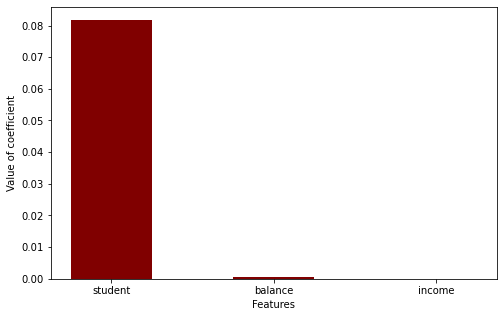

In [ ]:
courses = list(importance_L1.keys())
values = list(importance_L1.values())

fig = plt.figure(figsize = (8, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.5)

plt.xlabel("Features")
plt.ylabel("Value of coefficient")
plt.show()

Now let's apply different balancing techniques:


In [ ]:
import imblearn

Random oversampling:

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
training_set_x_L1_selection_over, training_set_y_over = oversample.fit_resample(training_set_x_L1_selection, training_set_y)

In [ ]:
training_set_x_L1_selection_over.shape

(13522, 2)

In [ ]:
training_set_y_over.shape

(13522, 1)

SMOTE:

In [ ]:
from imblearn.over_sampling import SMOTE
training_set_x_L1_selection_SMOTE, training_set_y_SMOTE = SMOTE().fit_resample(training_set_x_L1_selection, training_set_y)

In [ ]:
training_set_x_L1_selection_SMOTE.shape

(13522, 2)

In [ ]:
training_set_y_SMOTE.shape

(13522, 1)

SMOTETomek:

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=12)
training_set_x_L1_selection_SMOTETomek, training_set_y_SMOTETomek = smt.fit_resample(training_set_x_L1_selection, training_set_y)

In [ ]:
training_set_x_L1_selection_SMOTETomek.shape

(12592, 2)

In [ ]:
training_set_y_SMOTETomek.shape

(12592, 1)

SMOTE and one sided selection:

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection
training_set_x_L1_selection_SMOTE, training_set_y_SMOTE = SMOTE().fit_resample(training_set_x_L1_selection, training_set_y)
Oss = OneSidedSelection(random_state=42)
training_set_x_L1_selection_SMOTE_Oss, training_set_y_SMOTE_Oss = Oss.fit_resample(training_set_x_L1_selection_SMOTE, training_set_y_SMOTE)

In [ ]:
training_set_x_L1_selection_SMOTE_Oss.shape

(13024, 2)

In [ ]:
training_set_y_SMOTE_Oss.shape

(13024, 1)

now lets train our different training datasets on different models:

1-Random Forest:

Training on imbalanced training set:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_L1_selection_imbalanced_RF = RandomForestClassifier(random_state=3)
clf_L1_selection_imbalanced_RF.fit(training_set_x_L1_selection,training_set_y)


RandomForestClassifier(random_state=3)

Training on randomoversampled training set:

In [ ]:
clf_L1_selection_over_RF = RandomForestClassifier(random_state=3)
clf_L1_selection_over_RF.fit(training_set_x_L1_selection_over, training_set_y_over)

RandomForestClassifier(random_state=3)

Training on SMOTE training set:

In [ ]:
clf_L1_selection_SMOTE_RF = RandomForestClassifier(random_state=3)
clf_L1_selection_SMOTE_RF.fit(training_set_x_L1_selection_SMOTE, training_set_y_SMOTE)

RandomForestClassifier(random_state=3)

Training on SMOTETomek training set:

In [ ]:
clf_L1_selection_SMOTETomek_RF = RandomForestClassifier(random_state=3)
clf_L1_selection_SMOTETomek_RF.fit(training_set_x_L1_selection_SMOTETomek, training_set_y_SMOTETomek)

RandomForestClassifier(random_state=3)

Training on SMOTE_oss training set:

In [ ]:
clf_L1_selection_SMOTE_Oss_RF = RandomForestClassifier(random_state=3)
clf_L1_selection_SMOTE_Oss_RF.fit(training_set_x_L1_selection_SMOTE_Oss, training_set_y_SMOTE_Oss)

RandomForestClassifier(random_state=3)

2-Neural Network:

Training on imbalanced training set:

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
clf_L1_selection_imbalanced_NN = Sequential([Dense(units=2, activation='sigmoid') , Dense(units=2, activation='sigmoid'),Dense(units=1, activation='linear')])
clf_L1_selection_imbalanced_NN.compile(loss=BinaryCrossentropy(from_logits=True))
clf_L1_selection_imbalanced_NN.fit(training_set_x_L1_selection,training_set_y,epochs=100)


Epoch 1/100
219/219 [==============================] - 0s 636us/step - loss: 0.3598
Epoch 2/100
219/219 [==============================] - 0s 575us/step - loss: 0.2543
Epoch 3/100
219/219 [==============================] - 0s 576us/step - loss: 0.1914
Epoch 4/100
219/219 [==============================] - 0s 552us/step - loss: 0.1608
Epoch 5/100
219/219 [==============================] - 0s 575us/step - loss: 0.1511
Epoch 6/100
219/219 [==============================] - 0s 543us/step - loss: 0.1488
Epoch 7/100
219/219 [==============================] - 0s 557us/step - loss: 0.1482
Epoch 8/100
219/219 [==============================] - 0s 580us/step - loss: 0.1479
Epoch 9/100
219/219 [==============================] - 0s 530us/step - loss: 0.1427
Epoch 10/100
219/219 [==============================] - 0s 571us/step - loss: 0.1417
Epoch 11/100
219/219 [==============================] - 0s 533us/step - loss: 0.1406
Epoch 12/100
219/219 [==============================] - 0s 525us/step - lo

219/219 [==============================] - 0s 553us/step - loss: 0.1055
Epoch 97/100
219/219 [==============================] - 0s 603us/step - loss: 0.1032
Epoch 98/100
219/219 [==============================] - 0s 566us/step - loss: 0.1021
Epoch 99/100
219/219 [==============================] - 0s 571us/step - loss: 0.1015
Epoch 100/100
219/219 [==============================] - 0s 612us/step - loss: 0.1048


Training on randomoversampled training set:

In [ ]:
clf_L1_selection_over_NN = Sequential([Dense(units=2, activation='sigmoid') , Dense(units=2, activation='sigmoid'),Dense(units=1, activation='linear')])
clf_L1_selection_over_NN.compile(loss=BinaryCrossentropy(from_logits=True))
clf_L1_selection_over_NN.fit(training_set_x_L1_selection_over, training_set_y_over,epochs=100)


Epoch 1/100
423/423 [==============================] - 0s 560us/step - loss: 0.6961
Epoch 2/100
423/423 [==============================] - 0s 574us/step - loss: 0.6931
Epoch 3/100
423/423 [==============================] - 0s 539us/step - loss: 0.6858
Epoch 4/100
423/423 [==============================] - 0s 560us/step - loss: 0.6752
Epoch 5/100
423/423 [==============================] - 0s 542us/step - loss: 0.6595
Epoch 6/100
423/423 [==============================] - 0s 560us/step - loss: 0.6379
Epoch 7/100
423/423 [==============================] - 0s 560us/step - loss: 0.6082 0s - loss: 0.
Epoch 8/100
423/423 [==============================] - 0s 543us/step - loss: 0.5756
Epoch 9/100
423/423 [==============================] - 0s 570us/step - loss: 0.5392
Epoch 10/100
423/423 [==============================] - 0s 543us/step - loss: 0.5041
Epoch 11/100
423/423 [==============================] - 0s 552us/step - loss: 0.4510
Epoch 12/100
423/423 [==============================] - 0s 5

423/423 [==============================] - 0s 546us/step - loss: 0.3234
Epoch 97/100
423/423 [==============================] - 0s 546us/step - loss: 0.3241
Epoch 98/100
423/423 [==============================] - 0s 574us/step - loss: 0.3285
Epoch 99/100
423/423 [==============================] - 0s 591us/step - loss: 0.3277
Epoch 100/100
423/423 [==============================] - 0s 566us/step - loss: 0.3238


Training on SMOTE training set:

In [ ]:
clf_L1_selection_SMOTE_NN = Sequential([Dense(units=2, activation='sigmoid') , Dense(units=2, activation='sigmoid'),Dense(units=1, activation='linear')])
clf_L1_selection_SMOTE_NN.compile(loss=BinaryCrossentropy(from_logits=True))
clf_L1_selection_SMOTE_NN.fit(training_set_x_L1_selection_SMOTE, training_set_y_SMOTE,epochs=100)


Epoch 1/100
423/423 [==============================] - 0s 567us/step - loss: 0.7077
Epoch 2/100
423/423 [==============================] - 0s 537us/step - loss: 0.6938
Epoch 3/100
423/423 [==============================] - 0s 532us/step - loss: 0.6928
Epoch 4/100
423/423 [==============================] - 0s 537us/step - loss: 0.6916
Epoch 5/100
423/423 [==============================] - 0s 527us/step - loss: 0.6905
Epoch 6/100
423/423 [==============================] - 0s 551us/step - loss: 0.6891
Epoch 7/100
423/423 [==============================] - 0s 543us/step - loss: 0.6878
Epoch 8/100
423/423 [==============================] - 0s 537us/step - loss: 0.6865
Epoch 9/100
423/423 [==============================] - 0s 563us/step - loss: 0.6851
Epoch 10/100
423/423 [==============================] - 0s 540us/step - loss: 0.6259
Epoch 11/100
423/423 [==============================] - 0s 536us/step - loss: 0.5600
Epoch 12/100
423/423 [==============================] - 0s 560us/step - lo

423/423 [==============================] - 0s 573us/step - loss: 0.3406
Epoch 98/100
423/423 [==============================] - 0s 584us/step - loss: 0.3363
Epoch 99/100
423/423 [==============================] - 0s 537us/step - loss: 0.3387
Epoch 100/100
423/423 [==============================] - 0s 541us/step - loss: 0.3387


Training on SMOTETomek training set:

In [ ]:
clf_L1_selection_SMOTETomek_NN = Sequential([Dense(units=2, activation='sigmoid') , Dense(units=2,activation='sigmoid'),Dense(units=1, activation='linear')])
clf_L1_selection_SMOTETomek_NN.compile(loss=BinaryCrossentropy(from_logits=True))
clf_L1_selection_SMOTETomek_NN.fit(training_set_x_L1_selection_SMOTETomek, training_set_y_SMOTETomek,epochs=100)

Epoch 1/100
394/394 [==============================] - 0s 574us/step - loss: 0.6933
Epoch 2/100
394/394 [==============================] - 0s 536us/step - loss: 0.6925
Epoch 3/100
394/394 [==============================] - 0s 510us/step - loss: 0.6893
Epoch 4/100
394/394 [==============================] - 0s 540us/step - loss: 0.6834
Epoch 5/100
394/394 [==============================] - 0s 557us/step - loss: 0.6718
Epoch 6/100
394/394 [==============================] - 0s 536us/step - loss: 0.6523
Epoch 7/100
394/394 [==============================] - 0s 547us/step - loss: 0.6230
Epoch 8/100
394/394 [==============================] - 0s 548us/step - loss: 0.5843
Epoch 9/100
394/394 [==============================] - 0s 536us/step - loss: 0.5406
Epoch 10/100
394/394 [==============================] - 0s 547us/step - loss: 0.4989
Epoch 11/100
394/394 [==============================] - 0s 548us/step - loss: 0.4559
Epoch 12/100
394/394 [==============================] - 0s 524us/step - lo

394/394 [==============================] - 0s 513us/step - loss: 0.2702
Epoch 97/100
394/394 [==============================] - 0s 546us/step - loss: 0.2737
Epoch 98/100
394/394 [==============================] - 0s 556us/step - loss: 0.2696
Epoch 99/100
394/394 [==============================] - 0s 532us/step - loss: 0.2680
Epoch 100/100
394/394 [==============================] - 0s 527us/step - loss: 0.2696


Training on SMOTE_Oss training set:

In [ ]:
clf_L1_selection_SMOTE_Oss_NN = Sequential([Dense(units=2, activation='sigmoid') , Dense(units=2, activation='sigmoid'),Dense(units=1, activation='linear')])
clf_L1_selection_SMOTE_Oss_NN.compile(loss=BinaryCrossentropy(from_logits=True))
clf_L1_selection_SMOTE_Oss_NN.fit(training_set_x_L1_selection_SMOTE_Oss, training_set_y_SMOTE_Oss,epochs=100)

Epoch 1/100
407/407 [==============================] - 0s 543us/step - loss: 0.6924
Epoch 2/100
407/407 [==============================] - 0s 531us/step - loss: 0.6920
Epoch 3/100
407/407 [==============================] - 0s 520us/step - loss: 0.6916
Epoch 4/100
407/407 [==============================] - 0s 527us/step - loss: 0.6889
Epoch 5/100
407/407 [==============================] - 0s 519us/step - loss: 0.6683
Epoch 6/100
407/407 [==============================] - 0s 530us/step - loss: 0.6387
Epoch 7/100
407/407 [==============================] - 0s 548us/step - loss: 0.5995
Epoch 8/100
407/407 [==============================] - 0s 550us/step - loss: 0.5539
Epoch 9/100
407/407 [==============================] - 0s 531us/step - loss: 0.5059
Epoch 10/100
407/407 [==============================] - 0s 541us/step - loss: 0.4568
Epoch 11/100
407/407 [==============================] - 0s 522us/step - loss: 0.4222
Epoch 12/100
407/407 [==============================] - 0s 531us/step - lo

407/407 [==============================] - 0s 531us/step - loss: 0.2969
Epoch 97/100
407/407 [==============================] - 0s 538us/step - loss: 0.2932
Epoch 98/100
407/407 [==============================] - 0s 528us/step - loss: 0.3016
Epoch 99/100
407/407 [==============================] - 0s 587us/step - loss: 0.2989
Epoch 100/100
407/407 [==============================] - 0s 531us/step - loss: 0.2933


3-XGBoost:

Training on imbalanced training set:

In [ ]:
from xgboost import XGBClassifier
clf_L1_selection_imbalanced_XGB= XGBClassifier()
clf_L1_selection_imbalanced_XGB.fit(training_set_x_L1_selection,training_set_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Training on randomoversampled training set:

In [ ]:
clf_L1_selection_over_XGB= XGBClassifier()
clf_L1_selection_over_XGB.fit(training_set_x_L1_selection_over, training_set_y_over)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Training on SMOTE training set:

In [ ]:
clf_L1_selection_SMOTE_XGB= XGBClassifier()
clf_L1_selection_SMOTE_XGB.fit(training_set_x_L1_selection_SMOTE, training_set_y_SMOTE)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Training on SMOTETomek training set:

In [ ]:
clf_L1_selection_SMOTETomek_XGB= XGBClassifier()
clf_L1_selection_SMOTETomek_XGB.fit(training_set_x_L1_selection_SMOTETomek, training_set_y_SMOTETomek)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Training on SMOTE_Oss training set:

In [ ]:
clf_L1_selection_SMOTE_Oss_XGB= XGBClassifier()
clf_L1_selection_SMOTE_Oss_XGB.fit(training_set_x_L1_selection_SMOTE_Oss, training_set_y_SMOTE_Oss)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

4-Logistic Regression:

Training on imbalanced training set:

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_L1_selection_imbalanced_LR= LogisticRegression(random_state=3)
clf_L1_selection_imbalanced_LR.fit(training_set_x_L1_selection,training_set_y)


LogisticRegression(random_state=3)

Training on randomoversampled training set:

In [ ]:
clf_L1_selection_over_LR= LogisticRegression(random_state=3)
clf_L1_selection_over_LR.fit(training_set_x_L1_selection_over, training_set_y_over)

LogisticRegression(random_state=3)

Training on SMOTE training set:

In [ ]:
clf_L1_selection_SMOTE_LR= LogisticRegression(random_state=3)
clf_L1_selection_SMOTE_LR.fit(training_set_x_L1_selection_SMOTE, training_set_y_SMOTE)

LogisticRegression(random_state=3)

Training on SMOTETomek training set:

In [ ]:
clf_L1_selection_SMOTETomek_LR= LogisticRegression(random_state=3)
clf_L1_selection_SMOTETomek_LR.fit(training_set_x_L1_selection_SMOTETomek, training_set_y_SMOTETomek)

LogisticRegression(random_state=3)

Training on SMOTE_Oss training set:

In [ ]:
clf_L1_selection_SMOTE_Oss_LR= LogisticRegression(random_state=3)
clf_L1_selection_SMOTE_Oss_LR.fit(training_set_x_L1_selection_SMOTE_Oss, training_set_y_SMOTE_Oss)

LogisticRegression(random_state=3)

Now lets measure the performance of our models and visualize them :

Accuracy:

1-L1 based feature selection:

1-Random forest models:

In [ ]:
testing_set_y = testing_set.loc[:, "default":"default"]
testing_set_y.head()

,default
1,0
6,0
7,0
8,0
11,0


In [ ]:
testing_set_y.shape

(3000, 1)

In [ ]:
testing_set_x = testing_set.loc[:, "student": "income"]
testing_set_x.head()

,student,balance,income
1,1,817.180407,12106.13470
6,0,825.513331,24905.22658
7,1,808.667504,17600.45134
8,0,1161.057854,37468.52929
11,1,1220.583753,13268.56222


In [ ]:
testing_set_x.shape

(3000, 3)

In [ ]:
testing_set_x_L1_selection = model.transform(testing_set_x)

In [ ]:
testing_set_x_L1_selection.shape

(3000, 2)

In [ ]:
y_pred_clf_L1_selection_imbalanced_RF = clf_L1_selection_imbalanced_RF.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_over_RF = clf_L1_selection_over_RF.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_SMOTE_RF = clf_L1_selection_SMOTE_RF.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_SMOTETomek_RF = clf_L1_selection_SMOTETomek_RF.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_SMOTE_Oss_RF = clf_L1_selection_SMOTE_Oss_RF.predict(testing_set_x_L1_selection)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
Acc_clf_L1_selection_imbalanced_RF =accuracy_score(testing_set_y, y_pred_clf_L1_selection_imbalanced_RF)
print(Acc_clf_L1_selection_imbalanced_RF)

0.956


In [ ]:
Acc_clf_L1_selection_over_RF =accuracy_score(testing_set_y, y_pred_clf_L1_selection_over_RF)
print(Acc_clf_L1_selection_over_RF)

0.956


In [ ]:
Acc_clf_L1_selection_SMOTE_RF =accuracy_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_RF )
print(Acc_clf_L1_selection_SMOTE_RF)

0.896


In [ ]:
Acc_clf_L1_selection_SMOTETomek_RF =accuracy_score(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_RF)
print(Acc_clf_L1_selection_SMOTETomek_RF)

0.896


In [ ]:
Acc_clf_L1_selection_SMOTE_Oss_RF =accuracy_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_RF)
print(Acc_clf_L1_selection_SMOTE_Oss_RF)

0.916


2-Neural network:

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy

In [ ]:
logits_clf_L1_selection_imbalanced_NN = clf_L1_selection_imbalanced_NN(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_imbalanced_NN = tf.nn.sigmoid(logits_clf_L1_selection_imbalanced_NN)
y_pred_clf_L1_selection_imbalanced_NN.shape

TensorShape([3000, 1])

In [ ]:
y_pred_clf_L1_selection_imbalanced_NN.numpy()

array([[0.00308928],
       [0.00733405],
       [0.00304726],
       ...,
       [0.00278035],
       [0.00886554],
       [0.00346661]], dtype=float32)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(testing_set_y , y_pred_clf_L1_selection_imbalanced_NN)
Acc_clf_L1_selection_imbalanced_NN = m.result().numpy()
print(Acc_clf_L1_selection_imbalanced_NN)

0.9686667


In [ ]:
logits_clf_L1_selection_over_NN = clf_L1_selection_over_NN(testing_set_x_L1_selection)
y_pred_clf_L1_selection_over_NN = tf.nn.sigmoid(logits_clf_L1_selection_over_NN)
y_pred_clf_L1_selection_over_NN.shape

TensorShape([3000, 1])

In [ ]:
y_pred_clf_L1_selection_over_NN.numpy()

array([[0.04567438],
       [0.08330327],
       [0.04352891],
       ...,
       [0.01844993],
       [0.09103626],
       [0.04547301]], dtype=float32)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(testing_set_y , y_pred_clf_L1_selection_over_NN)
Acc_clf_L1_selection_over_NN = m.result().numpy()
print(Acc_clf_L1_selection_over_NN)

0.807


In [ ]:
logits_clf_L1_selection_SMOTE_NN = clf_L1_selection_SMOTE_NN(testing_set_x_L1_selection)
y_pred_clf_L1_selection_SMOTE_NN = tf.nn.sigmoid(logits_clf_L1_selection_SMOTE_NN)
y_pred_clf_L1_selection_SMOTE_NN.shape

TensorShape([3000, 1])

In [ ]:
y_pred_clf_L1_selection_SMOTE_NN.numpy()

array([[0.02996361],
       [0.0347909 ],
       [0.02975804],
       ...,
       [0.02726057],
       [0.0359832 ],
       [0.03007632]], dtype=float32)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_NN)
Acc_clf_L1_selection_SMOTE_NN = m.result().numpy()
print(Acc_clf_L1_selection_SMOTE_NN)

0.87733334


In [ ]:
logits_clf_L1_selection_SMOTETomek_NN = clf_L1_selection_SMOTETomek_NN(testing_set_x_L1_selection)
y_pred_clf_L1_selection_SMOTETomek_NN = tf.nn.sigmoid(logits_clf_L1_selection_SMOTETomek_NN)
y_pred_clf_L1_selection_SMOTETomek_NN.shape

TensorShape([3000, 1])

In [ ]:
y_pred_clf_L1_selection_SMOTETomek_NN.numpy()

array([[0.07829982],
       [0.24143079],
       [0.07193938],
       ...,
       [0.01746082],
       [0.29010755],
       [0.06284931]], dtype=float32)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTETomek_NN)
Acc_clf_L1_selection_SMOTETomek_NN = m.result().numpy()
print(Acc_clf_L1_selection_SMOTETomek_NN)

0.613


In [ ]:
logits_clf_L1_selection_SMOTE_Oss_NN = clf_L1_selection_SMOTE_Oss_NN(testing_set_x_L1_selection)
y_pred_clf_L1_selection_SMOTE_Oss_NN = tf.nn.sigmoid(logits_clf_L1_selection_SMOTE_Oss_NN)
y_pred_clf_L1_selection_SMOTE_Oss_NN.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([3000, 1])

In [ ]:
y_pred_clf_L1_selection_SMOTE_Oss_NN.numpy()

array([[0.03364012],
       [0.03769389],
       [0.03303462],
       ...,
       [0.02034703],
       [0.04153025],
       [0.02475125]], dtype=float32)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_Oss_NN)
Acc_clf_L1_selection_SMOTE_Oss_NN = m.result().numpy()
print(Acc_clf_L1_selection_SMOTE_Oss_NN)

0.79733336


3-XGBoost:

In [ ]:
y_pred_clf_L1_selection_imbalanced_XGB = clf_L1_selection_imbalanced_XGB.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_over_XGB = clf_L1_selection_over_XGB.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_SMOTE_XGB = clf_L1_selection_SMOTE_XGB.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_SMOTETomek_XGB = clf_L1_selection_SMOTETomek_XGB.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_SMOTE_Oss_XGB = clf_L1_selection_SMOTE_Oss_XGB.predict(testing_set_x_L1_selection)

In [ ]:
Acc_clf_L1_selection_imbalanced_XGB =accuracy_score(testing_set_y, y_pred_clf_L1_selection_imbalanced_XGB )
print(Acc_clf_L1_selection_imbalanced_XGB)

0.971


In [ ]:
Acc_clf_L1_selection_over_XGB =accuracy_score(testing_set_y, y_pred_clf_L1_selection_over_XGB )
print(Acc_clf_L1_selection_over_XGB)

0.9396666666666667


In [ ]:
Acc_clf_L1_selection_SMOTE_XGB =accuracy_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_XGB )
print(Acc_clf_L1_selection_SMOTE_XGB)

0.9223333333333333


In [ ]:
Acc_clf_L1_selection_SMOTETomek_XGB =accuracy_score(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_XGB)
print(Acc_clf_L1_selection_SMOTETomek_XGB)

0.9143333333333333


In [ ]:
Acc_clf_L1_selection_SMOTE_Oss_XGB =accuracy_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_XGB )
print(Acc_clf_L1_selection_SMOTE_Oss_XGB)

0.9286666666666666


4-Logistic regression:

In [ ]:
y_pred_clf_L1_selection_imbalanced_LR = clf_L1_selection_imbalanced_LR.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_over_LR = clf_L1_selection_over_LR.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_SMOTE_LR = clf_L1_selection_SMOTE_LR.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_SMOTETomek_LR = clf_L1_selection_SMOTETomek_LR.predict(testing_set_x_L1_selection)

In [ ]:
y_pred_clf_L1_selection_SMOTE_Oss_LR = clf_L1_selection_SMOTE_Oss_LR.predict(testing_set_x_L1_selection)

In [ ]:
Acc_clf_L1_selection_imbalanced_LR =accuracy_score(testing_set_y, y_pred_clf_L1_selection_imbalanced_LR)
print(Acc_clf_L1_selection_imbalanced_LR)

0.9743333333333334


In [ ]:
Acc_clf_L1_selection_over_LR =accuracy_score(testing_set_y, y_pred_clf_L1_selection_over_LR )
print(Acc_clf_L1_selection_over_LR)

0.8696666666666667


In [ ]:
Acc_clf_L1_selection_SMOTE_LR =accuracy_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_LR)
print(Acc_clf_L1_selection_SMOTE_LR)

0.8696666666666667


In [ ]:
Acc_clf_L1_selection_SMOTETomek_LR =accuracy_score(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_LR)
print(Acc_clf_L1_selection_SMOTETomek_LR)

0.8693333333333333


In [ ]:
Acc_clf_L1_selection_SMOTE_Oss_LR =accuracy_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_LR )
print(Acc_clf_L1_selection_SMOTE_Oss_LR)

0.8856666666666667


Sensitivity and specificity:

1-Random forest

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_imbalanced_RF).ravel()
Sensitivity_clf_L1_selection_imbalanced_RF = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_imbalanced_RF)

0.3020833333333333


In [ ]:

Specificity_clf_L1_selection_imbalanced_RF = tn / (tn+fp)
print(Specificity_clf_L1_selection_imbalanced_RF)

0.9769442532690984


In [ ]:
#from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_over_RF).ravel()
Sensitivity_clf_L1_selection_over_RF = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_over_RF)


0.3020833333333333


In [ ]:
Specificity_clf_L1_selection_over_RF = tn / (tn+fp)
print(Specificity_clf_L1_selection_over_RF)

0.9769442532690984


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_SMOTE_RF).ravel()
Sensitivity_clf_L1_selection_SMOTE_RF = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_SMOTE_RF)

0.15064102564102563


In [ ]:
Specificity_clf_L1_selection_SMOTE_RF = tn / (tn+fp)
print(Specificity_clf_L1_selection_SMOTE_RF)

0.9088093599449415


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_RF).ravel()
Sensitivity_clf_L1_selection_SMOTETomek_RF = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_SMOTETomek_RF)

0.16149068322981366


In [ ]:
Specificity_clf_L1_selection_SMOTETomek_RF = tn / (tn+fp)
print(Specificity_clf_L1_selection_SMOTETomek_RF)

0.9070887818306951


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_RF).ravel()
Sensitivity_clf_L1_selection_SMOTE_Oss_RF = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_SMOTE_Oss_RF)

0.17886178861788618


In [ ]:
Specificity_clf_L1_selection_SMOTE_Oss_RF = tn / (tn+fp)
print(Specificity_clf_L1_selection_SMOTE_Oss_RF)

0.930488644184446


2-Neural network

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.metrics import FalsePositives
from tensorflow.keras.metrics import FalseNegatives
from tensorflow.keras.metrics import TrueNegatives
from tensorflow.keras.metrics import TruePositives

In [ ]:
m = FalsePositives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_imbalanced_NN)
FP_clf_L1_selection_imbalanced_NN = m.result().numpy()
print(FP_clf_L1_selection_imbalanced_NN)

0.0


In [ ]:
m = FalseNegatives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_imbalanced_NN)
FN_clf_L1_selection_imbalanced_NN = m.result().numpy()
print(FN_clf_L1_selection_imbalanced_NN)

94.0


In [ ]:
m = TruePositives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_imbalanced_NN)
TP_clf_L1_selection_imbalanced_NN = m.result().numpy()
print(TP_clf_L1_selection_imbalanced_NN)

0.0


In [ ]:
m = TrueNegatives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_imbalanced_NN)
TN_clf_L1_selection_imbalanced_NN = m.result().numpy()
print(TN_clf_L1_selection_imbalanced_NN)

2906.0


In [ ]:
Sensitivity_clf_L1_selection_imbalanced_NN = TP_clf_L1_selection_imbalanced_NN / (TP_clf_L1_selection_imbalanced_NN + FN_clf_L1_selection_imbalanced_NN)
print(Sensitivity_clf_L1_selection_imbalanced_NN)

0.0


In [ ]:
Specificity_clf_L1_selection_imbalanced_NN = TN_clf_L1_selection_imbalanced_NN / (TN_clf_L1_selection_imbalanced_NN + FP_clf_L1_selection_imbalanced_NN)
print(Specificity_clf_L1_selection_imbalanced_NN)

1.0


In [ ]:
m = FalsePositives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_over_NN)
FP_clf_L1_selection_over_NN = m.result().numpy()
print(FP_clf_L1_selection_over_NN)

572.0


In [ ]:
m = FalseNegatives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_over_NN)
FN_clf_L1_selection_over_NN = m.result().numpy()
print(FN_clf_L1_selection_over_NN)

7.0


In [ ]:
m = TruePositives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_over_NN)
TP_clf_L1_selection_over_NN = m.result().numpy()
print(TP_clf_L1_selection_over_NN)

87.0


In [ ]:
m = TrueNegatives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_over_NN)
TN_clf_L1_selection_over_NN = m.result().numpy()
print(TN_clf_L1_selection_over_NN)

2334.0


In [ ]:
Sensitivity_clf_L1_selection_over_NN = TP_clf_L1_selection_over_NN / (TP_clf_L1_selection_over_NN + FN_clf_L1_selection_over_NN)
print(Sensitivity_clf_L1_selection_over_NN)

0.9255319


In [ ]:
Specificity_clf_L1_selection_over_NN = TN_clf_L1_selection_over_NN / (TN_clf_L1_selection_over_NN + FP_clf_L1_selection_over_NN)
print(Specificity_clf_L1_selection_over_NN)

0.80316585


In [ ]:
m = FalsePositives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_NN)
FP_clf_L1_selection_SMOTE_NN = m.result().numpy()
print(FP_clf_L1_selection_SMOTE_NN)

357.0


In [ ]:
m = FalseNegatives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_NN)
FN_clf_L1_selection_SMOTE_NN = m.result().numpy()
print(FN_clf_L1_selection_SMOTE_NN)

11.0


In [ ]:
m = TruePositives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_NN)
TP_clf_L1_selection_SMOTE_NN = m.result().numpy()
print(TP_clf_L1_selection_SMOTE_NN)

83.0


In [ ]:
m = TrueNegatives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_NN)
TN_clf_L1_selection_SMOTE_NN = m.result().numpy()
print(TN_clf_L1_selection_SMOTE_NN)

2549.0


In [ ]:
Sensitivity_clf_L1_selection_SMOTE_NN = TP_clf_L1_selection_SMOTE_NN / (TP_clf_L1_selection_SMOTE_NN + FN_clf_L1_selection_SMOTE_NN)
print(Sensitivity_clf_L1_selection_SMOTE_NN)

0.88297874


In [ ]:
Specificity_clf_L1_selection_SMOTE_NN = TN_clf_L1_selection_SMOTE_NN / (TN_clf_L1_selection_SMOTE_NN + FP_clf_L1_selection_SMOTE_NN)
print(Specificity_clf_L1_selection_SMOTE_NN)

0.8771507


In [ ]:
m = FalsePositives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTETomek_NN)
FP_clf_L1_selection_SMOTETomek_NN = m.result().numpy()
print(FP_clf_L1_selection_SMOTETomek_NN)

1160.0


In [ ]:
m = FalseNegatives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTETomek_NN)
FN_clf_L1_selection_SMOTETomek_NN = m.result().numpy()
print(FN_clf_L1_selection_SMOTETomek_NN)

1.0


In [ ]:
m = TruePositives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTETomek_NN)
TP_clf_L1_selection_SMOTETomek_NN = m.result().numpy()
print(TP_clf_L1_selection_SMOTETomek_NN)

93.0


In [ ]:
m = TrueNegatives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTETomek_NN)
TN_clf_L1_selection_SMOTETomek_NN = m.result().numpy()
print(TN_clf_L1_selection_SMOTETomek_NN)

1746.0


In [ ]:
Sensitivity_clf_L1_selection_SMOTETomek_NN = TP_clf_L1_selection_SMOTETomek_NN / (TP_clf_L1_selection_SMOTETomek_NN + FN_clf_L1_selection_SMOTETomek_NN)
print(Sensitivity_clf_L1_selection_SMOTETomek_NN)

0.9893617


In [ ]:
Specificity_clf_L1_selection_SMOTETomek_NN = TN_clf_L1_selection_SMOTETomek_NN / (TN_clf_L1_selection_SMOTETomek_NN + FP_clf_L1_selection_SMOTETomek_NN)
print(Specificity_clf_L1_selection_SMOTETomek_NN)

0.6008259


In [ ]:
m = FalsePositives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_Oss_NN)
FP_clf_L1_selection_SMOTE_Oss_NN = m.result().numpy()
print(FP_clf_L1_selection_SMOTE_Oss_NN)

601.0


In [ ]:
m = FalseNegatives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_Oss_NN)
FN_clf_L1_selection_SMOTE_Oss_NN = m.result().numpy()
print(FN_clf_L1_selection_SMOTE_Oss_NN)

7.0


In [ ]:
m = TruePositives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_Oss_NN)
TP_clf_L1_selection_SMOTE_Oss_NN = m.result().numpy()
print(TP_clf_L1_selection_SMOTE_Oss_NN)

87.0


In [ ]:
m = TrueNegatives()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_Oss_NN)
TN_clf_L1_selection_SMOTE_Oss_NN = m.result().numpy()
print(TN_clf_L1_selection_SMOTE_Oss_NN)

2305.0


In [ ]:
Sensitivity_clf_L1_selection_SMOTE_Oss_NN = TP_clf_L1_selection_SMOTE_Oss_NN / (TP_clf_L1_selection_SMOTE_Oss_NN + FN_clf_L1_selection_SMOTE_Oss_NN)
print(Sensitivity_clf_L1_selection_SMOTE_Oss_NN)

0.9255319


In [ ]:
Specificity_clf_L1_selection_SMOTE_Oss_NN = TN_clf_L1_selection_SMOTE_Oss_NN / (TN_clf_L1_selection_SMOTE_Oss_NN + FP_clf_L1_selection_SMOTE_Oss_NN)
print(Specificity_clf_L1_selection_SMOTE_Oss_NN)

0.7931865


3-XGBoost:

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_imbalanced_XGB).ravel()
Sensitivity_clf_L1_selection_imbalanced_XGB = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_imbalanced_XGB)

0.5636363636363636


In [ ]:

Specificity_clf_L1_selection_imbalanced_XGB = tn / (tn+fp)
print(Specificity_clf_L1_selection_imbalanced_XGB)

0.9917412250516173


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_over_XGB).ravel()
Sensitivity_clf_L1_selection_over_XGB = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_over_XGB)


0.27225130890052357


In [ ]:
Specificity_clf_L1_selection_over_XGB = tn / (tn+fp)
print(Specificity_clf_L1_selection_over_XGB)

0.9521679284239505


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_SMOTE_XGB).ravel()
Sensitivity_clf_L1_selection_SMOTE_XGB = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_SMOTE_XGB)

0.23371647509578544


In [ ]:
Specificity_clf_L1_selection_SMOTE_XGB = tn / (tn+fp)
print(Specificity_clf_L1_selection_SMOTE_XGB)

0.9311768754301445


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_XGB).ravel()
Sensitivity_clf_L1_selection_SMOTETomek_XGB = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_SMOTETomek_XGB)

0.2078853046594982


In [ ]:
Specificity_clf_L1_selection_SMOTETomek_XGB = tn / (tn+fp)
print(Specificity_clf_L1_selection_SMOTETomek_XGB)

0.9239504473503097


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_XGB).ravel()
Sensitivity_clf_L1_selection_SMOTE_Oss_XGB = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_SMOTE_Oss_XGB)

0.23684210526315788


In [ ]:
Specificity_clf_L1_selection_SMOTE_Oss_XGB = tn / (tn+fp)
print(Specificity_clf_L1_selection_SMOTE_Oss_XGB)

0.9401238816242258


4-logistic Regression

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_imbalanced_LR).ravel()
Sensitivity_clf_L1_selection_imbalanced_LR = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_imbalanced_LR)

0.7428571428571429


In [ ]:

Specificity_clf_L1_selection_imbalanced_LR = tn / (tn+fp)
print(Specificity_clf_L1_selection_imbalanced_LR)

0.9969029593943565


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_over_LR).ravel()
Sensitivity_clf_L1_selection_over_LR = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_over_LR)


0.18201284796573874


In [ ]:
Specificity_clf_L1_selection_over_LR = tn / (tn+fp)
print(Specificity_clf_L1_selection_over_LR)

0.868547832071576


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_SMOTE_LR).ravel()
Sensitivity_clf_L1_selection_SMOTE_LR = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_SMOTE_LR)

0.18201284796573874


In [ ]:
Specificity_clf_L1_selection_SMOTE_LR = tn / (tn+fp)
print(Specificity_clf_L1_selection_SMOTE_LR)

0.868547832071576


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_LR).ravel()
Sensitivity_clf_L1_selection_SMOTETomek_LR = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_SMOTETomek_LR)

0.18162393162393162


In [ ]:
Specificity_clf_L1_selection_SMOTETomek_LR = tn / (tn+fp)
print(Specificity_clf_L1_selection_SMOTETomek_LR)

0.8682037164487267


In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_LR).ravel()
Sensitivity_clf_L1_selection_SMOTE_Oss_LR = tp / (tp+fp)
print(Sensitivity_clf_L1_selection_SMOTE_Oss_LR)

0.19708029197080293


In [ ]:
Specificity_clf_L1_selection_SMOTE_Oss_LR = tn / (tn+fp)
print(Specificity_clf_L1_selection_SMOTE_Oss_LR)

0.8864418444597385


4-AUC ROC

1-Random forest

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
Auc_clf_L1_selection_imbalanced_RF = roc_auc_score(testing_set_y, y_pred_clf_L1_selection_imbalanced_RF)
print(Auc_clf_L1_selection_imbalanced_RF)

0.6427274457834854


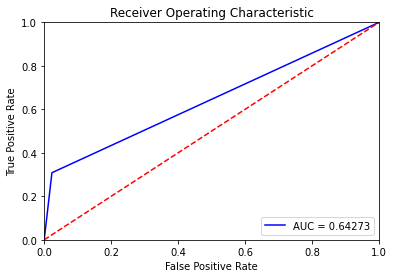

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_imbalanced_RF)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_over_RF =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_over_RF)
print(Auc_clf_L1_selection_over_RF)

0.6427274457834854


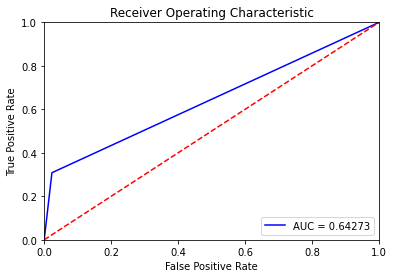

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_over_RF)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_SMOTE_RF =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_RF )
print(Auc_clf_L1_selection_SMOTE_RF)

0.7044046799724707


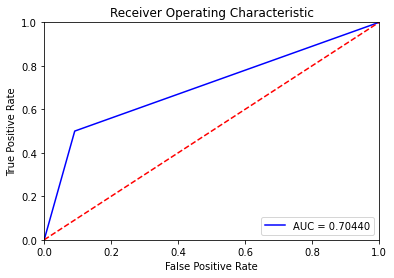

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_SMOTE_RF)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_SMOTETomek_RF =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_RF)
print(Auc_clf_L1_selection_SMOTETomek_RF)

0.7301401355961986


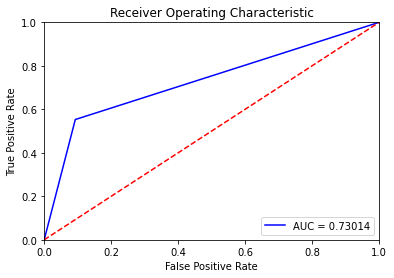

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_RF)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_SMOTE_Oss_RF =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_RF)
print(Auc_clf_L1_selection_SMOTE_Oss_RF)

0.6992868752837124


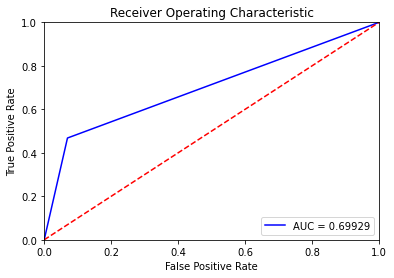

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_RF)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

2-Neural network

In [ ]:
from tensorflow.keras.metrics import AUC

In [ ]:
m = AUC()
m.update_state(testing_set_y , y_pred_clf_L1_selection_imbalanced_NN)
Auc_clf_L1_selection_imbalanced_NN = m.result().numpy()
print(Auc_clf_L1_selection_imbalanced_NN)


0.9464297


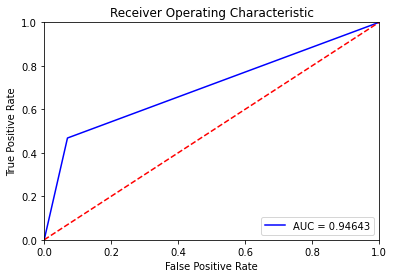

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % Auc_clf_L1_selection_imbalanced_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
m = AUC()
m.update_state(testing_set_y , y_pred_clf_L1_selection_over_NN)
Auc_clf_L1_selection_over_NN = m.result().numpy()
print(Auc_clf_L1_selection_over_NN)


0.949049


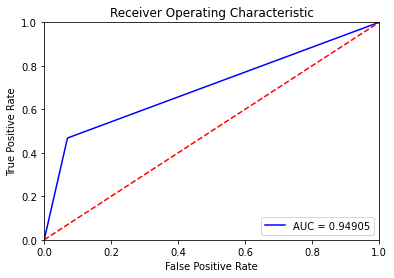

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % Auc_clf_L1_selection_over_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
m = AUC()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_NN)
Auc_clf_L1_selection_SMOTE_NN = m.result().numpy()
print(Auc_clf_L1_selection_SMOTE_NN)


0.9469476


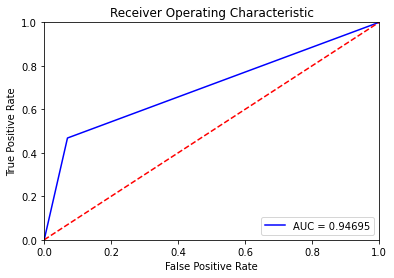

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % Auc_clf_L1_selection_SMOTE_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
m = AUC()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTETomek_NN)
Auc_clf_L1_selection_SMOTETomek_NN = m.result().numpy()
print(Auc_clf_L1_selection_SMOTETomek_NN)


0.9394724


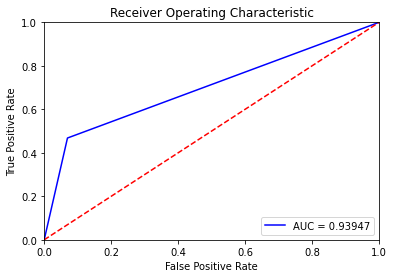

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % Auc_clf_L1_selection_SMOTETomek_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
m = AUC()
m.update_state(testing_set_y , y_pred_clf_L1_selection_SMOTE_Oss_NN)
Auc_clf_L1_selection_SMOTE_Oss_NN = m.result().numpy()
print(Auc_clf_L1_selection_SMOTE_Oss_NN)


0.93841803


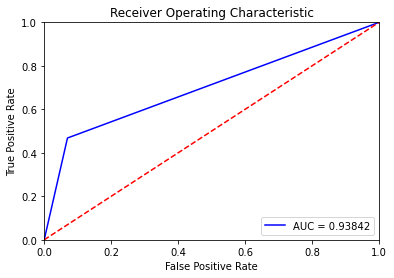

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % Auc_clf_L1_selection_SMOTE_Oss_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

3-XGBoost

In [ ]:
Auc_clf_L1_selection_imbalanced_XGB = roc_auc_score(testing_set_y, y_pred_clf_L1_selection_imbalanced_XGB)
print(Auc_clf_L1_selection_imbalanced_XGB)

0.6607642295470852


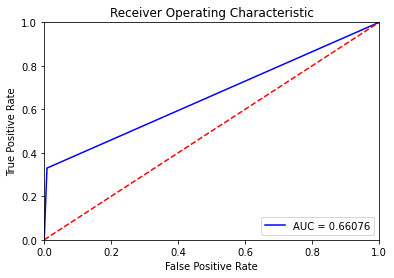

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_imbalanced_XGB)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_over_XGB =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_over_XGB)
print(Auc_clf_L1_selection_over_XGB)

0.7526797088928263


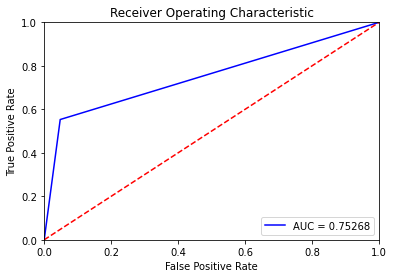

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_over_XGB)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_SMOTE_XGB =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_XGB )
print(Auc_clf_L1_selection_SMOTE_XGB)

0.7900565228214552


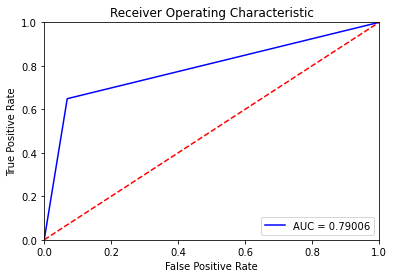

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_SMOTE_XGB)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_SMOTETomek_XGB =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_XGB)
print(Auc_clf_L1_selection_SMOTETomek_XGB)

0.7704858619730273


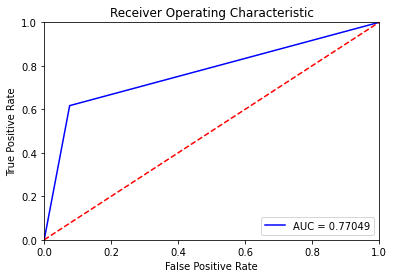

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_XGB)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_SMOTE_Oss_XGB =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_XGB)
print(Auc_clf_L1_selection_SMOTE_Oss_XGB)

0.7572959833653045


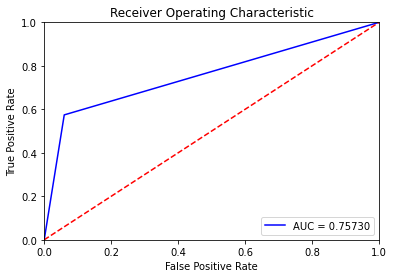

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_XGB)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

4-Logistic Regression

In [ ]:
Auc_clf_L1_selection_imbalanced_LR = roc_auc_score(testing_set_y, y_pred_clf_L1_selection_imbalanced_LR)
print(Auc_clf_L1_selection_imbalanced_LR)

0.6367493520376037


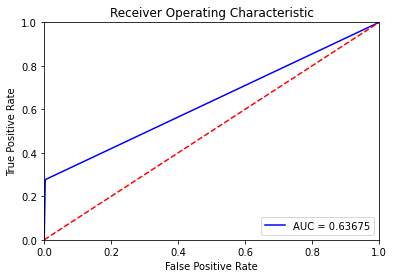

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_imbalanced_LR)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_over_LR =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_over_LR)
print(Auc_clf_L1_selection_over_LR)

0.8864015756102561


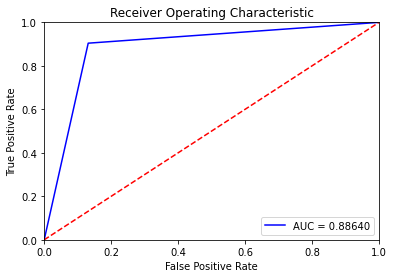

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_over_LR)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_SMOTE_LR =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_LR)
print(Auc_clf_L1_selection_SMOTE_LR)

0.8864015756102561


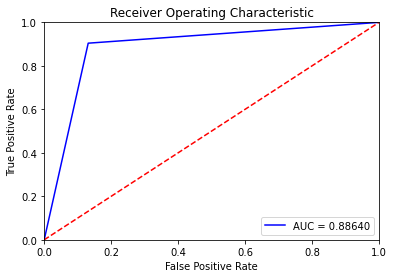

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_SMOTE_LR)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_SMOTETomek_LR =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_LR)
print(Auc_clf_L1_selection_SMOTETomek_LR)

0.8862295177988314


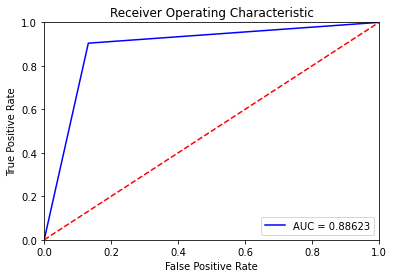

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_SMOTETomek_LR)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_L1_selection_SMOTE_Oss_LR =roc_auc_score(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_LR)
print(Auc_clf_L1_selection_SMOTE_Oss_LR)

0.8740719860596565


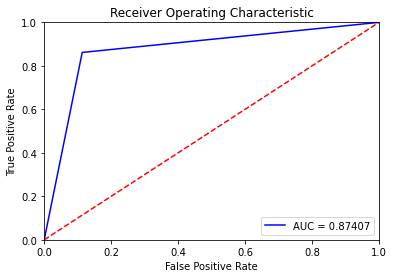

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_L1_selection_SMOTE_Oss_LR)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Now lets show everything in a table:

In [ ]:
import pandas as pd

In [ ]:
data = {'Models':  ['RF—imbalanced ', 'RF—RandOverSampling', 'RF—SMOTE' , 'RF—SMOTETomek' , 'RF—SMOTEOss' ,

                   'NN—imbalanced ', 'NN—RandOverSampling', 'NN—SMOTE' , 'NN—SMOTETomek' , 'NN—SMOTEOss',
                    'XGB—imbalanced ', 'XGB—RandOverSampling', 'XGB—SMOTE' , 'XGB—SMOTETomek' , 'XGB—SMOTEOss' ,

                   'LR—imbalanced ', 'LR—RandOverSampling', 'LR—SMOTE' , 'LR—SMOTETomek' , 'LR—SMOTEOss'
                   ],
        'Accuracy': [round(Acc_clf_L1_selection_imbalanced_RF, 3), round(Acc_clf_L1_selection_over_RF , 3), round(Acc_clf_L1_selection_SMOTE_RF, 3),
                    round(Acc_clf_L1_selection_SMOTETomek_RF, 3) , round(Acc_clf_L1_selection_SMOTE_Oss_RF, 3) ,

                    round(Acc_clf_L1_selection_imbalanced_NN, 3), round(Acc_clf_L1_selection_over_NN , 3), round(Acc_clf_L1_selection_SMOTE_NN, 3),
                    round(Acc_clf_L1_selection_SMOTETomek_NN, 3) , round(Acc_clf_L1_selection_SMOTE_Oss_NN, 3),

                     round(Acc_clf_L1_selection_imbalanced_XGB, 3), round(Acc_clf_L1_selection_over_XGB , 3), round(Acc_clf_L1_selection_SMOTE_XGB, 3),
                    round(Acc_clf_L1_selection_SMOTETomek_XGB, 3) , round(Acc_clf_L1_selection_SMOTE_Oss_XGB, 3) ,

                     round(Acc_clf_L1_selection_imbalanced_LR, 3), round(Acc_clf_L1_selection_over_LR , 3), round(Acc_clf_L1_selection_SMOTE_LR, 3),
                    round(Acc_clf_L1_selection_SMOTETomek_LR, 3) , round(Acc_clf_L1_selection_SMOTE_Oss_LR, 3)



                    ],
         'Sensetivity' : [round(Sensitivity_clf_L1_selection_imbalanced_RF, 3) , round( Sensitivity_clf_L1_selection_over_RF, 3),
                         round(Sensitivity_clf_L1_selection_SMOTE_RF , 3) , round(Sensitivity_clf_L1_selection_SMOTETomek_RF, 3) ,
                         round(Sensitivity_clf_L1_selection_SMOTE_Oss_RF , 3) ,

                         round(Sensitivity_clf_L1_selection_imbalanced_NN, 3) , round( Sensitivity_clf_L1_selection_over_NN, 3),
                         round(Sensitivity_clf_L1_selection_SMOTE_NN , 3) , round(Sensitivity_clf_L1_selection_SMOTETomek_NN, 3) ,
                         round(Sensitivity_clf_L1_selection_SMOTE_Oss_NN , 3) ,

                          round(Sensitivity_clf_L1_selection_imbalanced_XGB, 3) , round( Sensitivity_clf_L1_selection_over_XGB, 3),
                         round(Sensitivity_clf_L1_selection_SMOTE_XGB , 3) , round(Sensitivity_clf_L1_selection_SMOTETomek_XGB, 3) ,
                         round(Sensitivity_clf_L1_selection_SMOTE_Oss_XGB , 3) ,

                          round(Sensitivity_clf_L1_selection_imbalanced_LR, 3) , round( Sensitivity_clf_L1_selection_over_LR, 3),
                         round(Sensitivity_clf_L1_selection_SMOTE_LR , 3) , round(Sensitivity_clf_L1_selection_SMOTETomek_LR, 3) ,
                         round(Sensitivity_clf_L1_selection_SMOTE_Oss_LR , 3)






                         ],
        'Specificity' : [round(Specificity_clf_L1_selection_imbalanced_RF, 3) , round(Specificity_clf_L1_selection_over_RF, 3) ,
                        round(Specificity_clf_L1_selection_SMOTE_RF , 3) , round(Specificity_clf_L1_selection_SMOTETomek_RF ,3) ,
                        round(Specificity_clf_L1_selection_SMOTE_Oss_RF , 3) ,


                        round(Specificity_clf_L1_selection_imbalanced_NN, 3) , round(Specificity_clf_L1_selection_over_NN, 3) ,
                        round(Specificity_clf_L1_selection_SMOTE_NN , 3) , round(Specificity_clf_L1_selection_SMOTETomek_NN ,3) ,
                        round(Specificity_clf_L1_selection_SMOTE_Oss_NN , 3) ,

                         round(Specificity_clf_L1_selection_imbalanced_XGB, 3) , round(Specificity_clf_L1_selection_over_XGB, 3) ,
                        round(Specificity_clf_L1_selection_SMOTE_XGB , 3) , round(Specificity_clf_L1_selection_SMOTETomek_XGB ,3) ,
                        round(Specificity_clf_L1_selection_SMOTE_Oss_XGB , 3) ,

                         round(Specificity_clf_L1_selection_imbalanced_LR, 3) , round(Specificity_clf_L1_selection_over_LR, 3) ,
                        round(Specificity_clf_L1_selection_SMOTE_LR , 3) , round(Specificity_clf_L1_selection_SMOTETomek_LR ,3) ,
                        round(Specificity_clf_L1_selection_SMOTE_Oss_LR , 3)






                        ],
        'AUC' : [round(Auc_clf_L1_selection_imbalanced_RF, 3)  , round(Auc_clf_L1_selection_over_RF, 3) , round(Auc_clf_L1_selection_SMOTE_RF , 3),
                round(Auc_clf_L1_selection_SMOTETomek_RF  , 3),round( Auc_clf_L1_selection_SMOTETomek_RF , 3) ,


                 round(Auc_clf_L1_selection_imbalanced_NN, 3)  , round(Auc_clf_L1_selection_over_NN, 3) , round(Auc_clf_L1_selection_SMOTE_NN , 3),
                round(Auc_clf_L1_selection_SMOTETomek_NN  , 3),round( Auc_clf_L1_selection_SMOTETomek_NN , 3) ,


                 round(Auc_clf_L1_selection_imbalanced_XGB, 3)  , round(Auc_clf_L1_selection_over_XGB, 3) , round(Auc_clf_L1_selection_SMOTE_XGB , 3),
                round(Auc_clf_L1_selection_SMOTETomek_XGB  , 3),round( Auc_clf_L1_selection_SMOTETomek_XGB , 3) ,


                 round(Auc_clf_L1_selection_imbalanced_LR, 3)  , round(Auc_clf_L1_selection_over_LR, 3) , round(Auc_clf_L1_selection_SMOTE_LR , 3),
                round(Auc_clf_L1_selection_SMOTETomek_LR  , 3),round( Auc_clf_L1_selection_SMOTETomek_LR , 3) ,









                ]
        }

df = pd.DataFrame(data)

print(df)

                  Models  Accuracy  Sensetivity  Specificity    AUC
0         RF—imbalanced      0.956        0.302        0.977  0.643
1    RF—RandOverSampling     0.956        0.302        0.977  0.643
2               RF—SMOTE     0.896        0.151        0.909  0.704
3          RF—SMOTETomek     0.896        0.161        0.907  0.730
4            RF—SMOTEOss     0.916        0.179        0.930  0.730
5         NN—imbalanced      0.969        0.000        1.000  0.946
6    NN—RandOverSampling     0.807        0.926        0.803  0.949
7               NN—SMOTE     0.877        0.883        0.877  0.947
8          NN—SMOTETomek     0.613        0.989        0.601  0.939
9            NN—SMOTEOss     0.797        0.926        0.793  0.939
10       XGB—imbalanced      0.971        0.564        0.992  0.661
11  XGB—RandOverSampling     0.940        0.272        0.952  0.753
12             XGB—SMOTE     0.922        0.234        0.931  0.790
13        XGB—SMOTETomek     0.914        0.208 

In [ ]:
df.style.format(formatter={('Accuracy'): "{:.3f}",
                           ('Sensetivity'): "{:,.3f}" ,  ('Specificity'): "{:,.3f}" , ('AUC'): "{:,.3f}"
                          })

,Models,Accuracy,Sensetivity,Specificity,AUC
0,RF—imbalanced,0.956,0.302,0.977,0.643
1,RF—RandOverSampling,0.956,0.302,0.977,0.643
2,RF—SMOTE,0.896,0.151,0.909,0.704
3,RF—SMOTETomek,0.896,0.161,0.907,0.730
4,RF—SMOTEOss,0.916,0.179,0.930,0.730
5,NN—imbalanced,0.969,0.000,1.000,0.946
6,NN—RandOverSampling,0.807,0.926,0.803,0.949
7,NN—SMOTE,0.877,0.883,0.877,0.947
8,NN—SMOTETomek,0.613,0.989,0.601,0.939
9,NN—SMOTEOss,0.797,0.926,0.793,0.939


2-Random forest recursive feature elimination:

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
rfe_rf = RFE(RandomForestClassifier())
rfe_rf.fit(training_set_x , training_set_y)
training_set_x_RFE_RF_selection= rfe_rf.transform(training_set_x)
training_set_x_RFE_RF_selection.shape

(7000, 1)

In [ ]:
cls = RandomForestClassifier().fit(training_set_x , training_set_y)
cls.feature_importances_

array([0.00533612, 0.66810789, 0.32655599])

In [ ]:
training_set_y.shape

(7000, 1)

In [ ]:
coefs_RFE_RF = cls.feature_importances_

In [ ]:
names_RFE_RF = cls.feature_names_in_

In [ ]:
importance_RFE_RF = {}
for i in range(3):
    importance_RFE_RF[names_RFE_RF[i]] = coefs_RFE_RF[i]

In [ ]:
importance_RFE_RF = dict(sorted(importance_RFE_RF.items(), key=lambda item: item[1] , reverse=True))

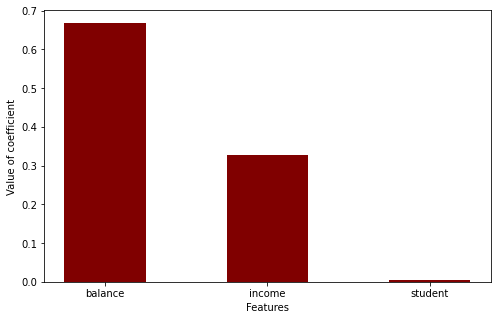

In [ ]:
courses = list(importance_RFE_RF.keys())
values = list(importance_RFE_RF.values())

fig = plt.figure(figsize = (8, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.5)

plt.xlabel("Features")
plt.ylabel("Value of coefficient")
plt.show()

Now let's apply different balancing techniques:

Random oversampling:

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
training_set_x_RFE_RF_selection_over, training_set_y_over = oversample.fit_resample(training_set_x_RFE_RF_selection, training_set_y)

In [ ]:
training_set_x_RFE_RF_selection_over.shape

(13522, 1)

In [ ]:
training_set_y_over.shape

(13522, 1)

SMOTE:

In [ ]:
from imblearn.over_sampling import SMOTE
training_set_x_RFE_RF_selection_SMOTE, training_set_y_SMOTE = SMOTE().fit_resample(training_set_x_RFE_RF_selection, training_set_y)

In [ ]:
training_set_x_RFE_RF_selection_SMOTE.shape

(13522, 1)

In [ ]:
training_set_y_SMOTE.shape

(13522, 1)

SMOTETomek:

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=12)
training_set_x_RFE_RF_selection_SMOTETomek, training_set_y_SMOTETomek = smt.fit_resample(training_set_x_RFE_RF_selection, training_set_y)

In [ ]:
training_set_x_RFE_RF_selection_SMOTETomek.shape

(12212, 1)

In [ ]:
training_set_y_SMOTETomek.shape

(12212, 1)

SMOTE and one sided selection:

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection
training_set_x_RFE_RF_selection_SMOTE, training_set_y_SMOTE = SMOTE().fit_resample(training_set_x_RFE_RF_selection, training_set_y)
Oss = OneSidedSelection(random_state=42)
training_set_x_RFE_RF_selection_SMOTE_Oss, training_set_y_SMOTE_Oss = Oss.fit_resample(training_set_x_RFE_RF_selection_SMOTE, training_set_y_SMOTE)

In [ ]:
training_set_x_RFE_RF_selection_SMOTE_Oss.shape

(12850, 1)

In [ ]:
training_set_y_SMOTE_Oss.shape

(12850, 1)

now lets train our different training datasets on different models:

1-Random Forest:

Training on imbalanced training set:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RFE_RF_selection_imbalanced_RF = RandomForestClassifier(random_state=3)
clf_RFE_RF_selection_imbalanced_RF.fit(training_set_x_RFE_RF_selection, training_set_y)

RandomForestClassifier(random_state=3)

Training on randomoversampled training set:

In [ ]:
clf_RFE_RF_selection_over_RF = RandomForestClassifier(random_state=3)
clf_RFE_RF_selection_over_RF.fit(training_set_x_RFE_RF_selection_over, training_set_y_over)

RandomForestClassifier(random_state=3)

Training on SMOTE training set:

In [ ]:
clf_RFE_RF_selection_SMOTE_RF = RandomForestClassifier(random_state=3)
clf_RFE_RF_selection_SMOTE_RF.fit(training_set_x_RFE_RF_selection_SMOTE, training_set_y_SMOTE)

RandomForestClassifier(random_state=3)

Training on SMOTETomek training set:

In [ ]:
clf_RFE_RF_selection_SMOTETomek_RF = RandomForestClassifier(random_state=3)
clf_RFE_RF_selection_SMOTETomek_RF.fit(training_set_x_RFE_RF_selection_SMOTETomek, training_set_y_SMOTETomek)

RandomForestClassifier(random_state=3)

Training on SMOTE_oss training set:

In [ ]:
clf_RFE_RF_selection_SMOTE_Oss_RF = RandomForestClassifier(random_state=3)
clf_RFE_RF_selection_SMOTE_Oss_RF.fit(training_set_x_RFE_RF_selection_SMOTE_Oss, training_set_y_SMOTE_Oss)

RandomForestClassifier(random_state=3)

2-Neural Network:

Training on imbalanced training set:

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
clf_RFE_RF_selection_imbalanced_NN = Sequential([Dense(units=1, activation='sigmoid') , Dense(units=1, activation='sigmoid'),Dense(units=1, activation='linear')])
clf_RFE_RF_selection_imbalanced_NN.compile(loss=BinaryCrossentropy(from_logits=True))
clf_RFE_RF_selection_imbalanced_NN.fit(training_set_x_RFE_RF_selection, training_set_y,epochs=100)

Epoch 1/100
219/219 [==============================] - 0s 767us/step - loss: 0.4917
Epoch 2/100
219/219 [==============================] - 0s 562us/step - loss: 0.3665
Epoch 3/100
219/219 [==============================] - 0s 512us/step - loss: 0.2676
Epoch 4/100
219/219 [==============================] - 0s 548us/step - loss: 0.2026
Epoch 5/100
219/219 [==============================] - 0s 575us/step - loss: 0.1676
Epoch 6/100
219/219 [==============================] - 0s 564us/step - loss: 0.1539
Epoch 7/100
219/219 [==============================] - 0s 612us/step - loss: 0.1499
Epoch 8/100
219/219 [==============================] - 0s 548us/step - loss: 0.1490
Epoch 9/100
219/219 [==============================] - 0s 548us/step - loss: 0.1488
Epoch 10/100
219/219 [==============================] - 0s 593us/step - loss: 0.1487
Epoch 11/100
219/219 [==============================] - 0s 594us/step - loss: 0.1487
Epoch 12/100
219/219 [==============================] - 0s 548us/step - lo

219/219 [==============================] - 0s 639us/step - loss: 0.1019
Epoch 98/100
219/219 [==============================] - 0s 618us/step - loss: 0.1039
Epoch 99/100
219/219 [==============================] - 0s 629us/step - loss: 0.1034
Epoch 100/100
219/219 [==============================] - 0s 650us/step - loss: 0.1023


Training on randomoversampled training set:

In [ ]:
clf_RFE_RF_selection_over_NN = Sequential([Dense(units=1, activation='sigmoid') , Dense(units=1, activation='sigmoid'),Dense(units=1, activation='linear')])
clf_RFE_RF_selection_over_NN.compile(loss=BinaryCrossentropy(from_logits=True))
clf_RFE_RF_selection_over_NN.fit(training_set_x_RFE_RF_selection_over, training_set_y_over,epochs=100)

Epoch 1/100
423/423 [==============================] - 0s 610us/step - loss: 0.7098
Epoch 2/100
423/423 [==============================] - 0s 564us/step - loss: 0.6925
Epoch 3/100
423/423 [==============================] - 0s 569us/step - loss: 0.6919
Epoch 4/100
423/423 [==============================] - 0s 573us/step - loss: 0.6918
Epoch 5/100
423/423 [==============================] - 0s 575us/step - loss: 0.6916
Epoch 6/100
423/423 [==============================] - 0s 593us/step - loss: 0.6914
Epoch 7/100
423/423 [==============================] - 0s 593us/step - loss: 0.6913
Epoch 8/100
423/423 [==============================] - 0s 575us/step - loss: 0.6910
Epoch 9/100
423/423 [==============================] - 0s 580us/step - loss: 0.6909
Epoch 10/100
423/423 [==============================] - 0s 575us/step - loss: 0.6908
Epoch 11/100
423/423 [==============================] - 0s 589us/step - loss: 0.6906
Epoch 12/100
423/423 [==============================] - 0s 580us/step - lo

423/423 [==============================] - 0s 622us/step - loss: 0.3467
Epoch 97/100
423/423 [==============================] - 0s 578us/step - loss: 0.3443
Epoch 98/100
423/423 [==============================] - 0s 546us/step - loss: 0.3474 0s - loss: 0.
Epoch 99/100
423/423 [==============================] - 0s 558us/step - loss: 0.3460
Epoch 100/100
423/423 [==============================] - 0s 562us/step - loss: 0.3475 0s - loss: 0.3


Training on SMOTE training set:

In [ ]:
clf_RFE_RF_selection_SMOTE_NN = Sequential([Dense(units=1, activation='sigmoid') , Dense(units=1, activation='sigmoid'),Dense(units=1, activation='linear')])
clf_RFE_RF_selection_SMOTE_NN.compile(loss=BinaryCrossentropy(from_logits=True))
clf_RFE_RF_selection_SMOTE_NN.fit(training_set_x_RFE_RF_selection_SMOTE, training_set_y_SMOTE,epochs=100)

Epoch 1/100
423/423 [==============================] - 0s 589us/step - loss: 0.7114
Epoch 2/100
423/423 [==============================] - 0s 553us/step - loss: 0.6945
Epoch 3/100
423/423 [==============================] - 0s 577us/step - loss: 0.6939 0s - loss: 0.694
Epoch 4/100
423/423 [==============================] - 0s 565us/step - loss: 0.6938
Epoch 5/100
423/423 [==============================] - 0s 563us/step - loss: 0.6936
Epoch 6/100
423/423 [==============================] - 0s 570us/step - loss: 0.6935
Epoch 7/100
423/423 [==============================] - 0s 551us/step - loss: 0.6935
Epoch 8/100
423/423 [==============================] - 0s 548us/step - loss: 0.6934
Epoch 9/100
423/423 [==============================] - 0s 572us/step - loss: 0.6934 0s - loss: 0.693
Epoch 10/100
423/423 [==============================] - 0s 574us/step - loss: 0.6933
Epoch 11/100
423/423 [==============================] - 0s 534us/step - loss: 0.6933
Epoch 12/100
423/423 [==================

Epoch 96/100
423/423 [==============================] - 0s 578us/step - loss: 0.6932
Epoch 97/100
423/423 [==============================] - 0s 524us/step - loss: 0.6932
Epoch 98/100
423/423 [==============================] - 0s 534us/step - loss: 0.6932
Epoch 99/100
423/423 [==============================] - 0s 557us/step - loss: 0.6932
Epoch 100/100
423/423 [==============================] - 0s 550us/step - loss: 0.6932


Training on SMOTETomek training set:

In [ ]:
clf_RFE_RF_selection_SMOTETomek_NN = Sequential([Dense(units=1, activation='sigmoid') , Dense(units=1, activation='sigmoid'),Dense(units=1, activation='linear')])
clf_RFE_RF_selection_SMOTETomek_NN.compile(loss=BinaryCrossentropy(from_logits=True))
clf_RFE_RF_selection_SMOTETomek_NN.fit(training_set_x_RFE_RF_selection_SMOTETomek, training_set_y_SMOTETomek,epochs=100)

Epoch 1/100
382/382 [==============================] - 0s 610us/step - loss: 0.7598
Epoch 2/100
382/382 [==============================] - 0s 524us/step - loss: 0.6858
Epoch 3/100
382/382 [==============================] - 0s 584us/step - loss: 0.6733
Epoch 4/100
382/382 [==============================] - 0s 555us/step - loss: 0.6646
Epoch 5/100
382/382 [==============================] - 0s 560us/step - loss: 0.6518
Epoch 6/100
382/382 [==============================] - 0s 573us/step - loss: 0.6351
Epoch 7/100
382/382 [==============================] - 0s 537us/step - loss: 0.6138
Epoch 8/100
382/382 [==============================] - 0s 539us/step - loss: 0.5884
Epoch 9/100
382/382 [==============================] - 0s 579us/step - loss: 0.5623
Epoch 10/100
382/382 [==============================] - 0s 574us/step - loss: 0.5350
Epoch 11/100
382/382 [==============================] - 0s 558us/step - loss: 0.5052
Epoch 12/100
382/382 [==============================] - 0s 558us/step - lo

382/382 [==============================] - 0s 558us/step - loss: 0.2572
Epoch 98/100
382/382 [==============================] - 0s 620us/step - loss: 0.2595
Epoch 99/100
382/382 [==============================] - 0s 605us/step - loss: 0.2566
Epoch 100/100
382/382 [==============================] - 0s 694us/step - loss: 0.2577 0s - loss: 0


Training on SMOTE_Oss training set:

In [ ]:
clf_RFE_RF_selection_SMOTE_Oss_NN = Sequential([Dense(units=1, activation='sigmoid') , Dense(units=1,activation='sigmoid'),Dense(units=1, activation='linear')])
clf_RFE_RF_selection_SMOTE_Oss_NN.compile(loss=BinaryCrossentropy(from_logits=True))
clf_RFE_RF_selection_SMOTE_Oss_NN.fit(training_set_x_RFE_RF_selection_SMOTE_Oss, training_set_y_SMOTE_Oss,epochs=100)

Epoch 1/100
402/402 [==============================] - 0s 587us/step - loss: 0.6983
Epoch 2/100
402/402 [==============================] - 0s 604us/step - loss: 0.6916
Epoch 3/100
402/402 [==============================] - 0s 555us/step - loss: 0.6912
Epoch 4/100
402/402 [==============================] - 0s 540us/step - loss: 0.6909
Epoch 5/100
402/402 [==============================] - 0s 572us/step - loss: 0.6902
Epoch 6/100
402/402 [==============================] - 0s 575us/step - loss: 0.6736
Epoch 7/100
402/402 [==============================] - 0s 570us/step - loss: 0.6577
Epoch 8/100
402/402 [==============================] - 0s 552us/step - loss: 0.6359
Epoch 9/100
402/402 [==============================] - 0s 592us/step - loss: 0.6086
Epoch 10/100
402/402 [==============================] - 0s 614us/step - loss: 0.5787
Epoch 11/100
402/402 [==============================] - 0s 614us/step - loss: 0.5483
Epoch 12/100
402/402 [==============================] - 0s 597us/step - lo

402/402 [==============================] - 0s 561us/step - loss: 0.3061
Epoch 98/100
402/402 [==============================] - 0s 567us/step - loss: 0.3030 0s - loss: 0.
Epoch 99/100
402/402 [==============================] - 0s 565us/step - loss: 0.3047
Epoch 100/100
402/402 [==============================] - 0s 569us/step - loss: 0.3035


3-XGBoost:

Training on imbalanced training set:

In [ ]:
from xgboost import XGBClassifier
clf_RFE_RF_selection_imbalanced_XGB= XGBClassifier()
clf_RFE_RF_selection_imbalanced_XGB.fit(training_set_x_RFE_RF_selection, training_set_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Training on randomoversampled training set:

In [ ]:
clf_RFE_RF_selection_over_XGB= XGBClassifier()
clf_RFE_RF_selection_over_XGB.fit(training_set_x_RFE_RF_selection_over, training_set_y_over)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Training on SMOTE training set:

In [ ]:
clf_RFE_RF_selection_SMOTE_XGB= XGBClassifier()
clf_RFE_RF_selection_SMOTE_XGB.fit(training_set_x_RFE_RF_selection_SMOTE, training_set_y_SMOTE)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Training on SMOTETomek training set:

In [ ]:
clf_RFE_RF_selection_SMOTETomek_XGB= XGBClassifier()
clf_RFE_RF_selection_SMOTETomek_XGB.fit(training_set_x_RFE_RF_selection_SMOTETomek, training_set_y_SMOTETomek)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Training on SMOTE_Oss training set:

In [ ]:
clf_RFE_RF_selection_SMOTE_Oss_XGB= XGBClassifier()
clf_RFE_RF_selection_SMOTE_Oss_XGB.fit(training_set_x_RFE_RF_selection_SMOTE_Oss, training_set_y_SMOTE_Oss)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

4-Logistic Regression:

Training on imbalanced training set:

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_RFE_RF_selection_imbalanced_LR= LogisticRegression(random_state=3)
clf_RFE_RF_selection_imbalanced_LR.fit(training_set_x_RFE_RF_selection, training_set_y)

LogisticRegression(random_state=3)

Training on randomoversampled training set:

In [ ]:
clf_RFE_RF_selection_over_LR= LogisticRegression(random_state=3)
clf_RFE_RF_selection_over_LR.fit(training_set_x_RFE_RF_selection_over, training_set_y_over)

LogisticRegression(random_state=3)

Training on SMOTE training set:

In [ ]:
clf_RFE_RF_selection_SMOTE_LR= LogisticRegression(random_state=3)
clf_RFE_RF_selection_SMOTE_LR.fit(training_set_x_RFE_RF_selection_SMOTE, training_set_y_SMOTE)

LogisticRegression(random_state=3)

Training on SMOTETomek training set:

In [ ]:
clf_RFE_RF_selection_SMOTETomek_LR= LogisticRegression(random_state=3)
clf_RFE_RF_selection_SMOTETomek_LR.fit(training_set_x_RFE_RF_selection_SMOTETomek, training_set_y_SMOTETomek)

LogisticRegression(random_state=3)

Training on SMOTE_Oss training set:

In [ ]:
clf_RFE_RF_selection_SMOTE_Oss_LR= LogisticRegression(random_state=3)
clf_RFE_RF_selection_SMOTE_Oss_LR.fit(training_set_x_RFE_RF_selection_SMOTE_Oss, training_set_y_SMOTE_Oss)

LogisticRegression(random_state=3)

Now lets measure the performance of our models and visualize them :

Accuracy:

1-Random forest models:

In [ ]:
testing_set_y = testing_set.loc[:, "default":"default"]
testing_set_y.head()

In [ ]:
testing_set_y.shape

In [ ]:
testing_set_x = testing_set.loc[:, "student": "income"]
testing_set_x.head()

In [ ]:
testing_set_x.shape

In [ ]:
testing_set_x_RFE_RF_selection = rfe_rf.transform(testing_set_x)

In [ ]:
testing_set_x_RFE_RF_selection.shape

In [ ]:
y_pred_clf_RFE_RF_selection_imbalanced_RF = clf_RFE_RF_selection_imbalanced_RF.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_over_RF = clf_RFE_RF_selection_over_RF.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTE_RF = clf_RFE_RF_selection_SMOTE_RF.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTETomek_RF = clf_RFE_RF_selection_SMOTETomek_RF.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTE_Oss_RF = clf_RFE_RF_selection_SMOTE_Oss_RF.predict(testing_set_x_RFE_RF_selection)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
Acc_clf_RFE_RF_selection_imbalanced_RF =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_RF)
print(Acc_clf_RFE_RF_selection_imbalanced_RF)

In [ ]:
Acc_clf_RFE_RF_selection_over_RF =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_over_RF)
print(Acc_clf_RFE_RF_selection_over_RF)

In [ ]:
Acc_clf_RFE_RF_selection_SMOTE_RF =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_RF )
print(Acc_clf_RFE_RF_selection_SMOTE_RF)

In [ ]:
Acc_clf_RFE_RF_selection_SMOTETomek_RF =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_RF)
print(Acc_clf_RFE_RF_selection_SMOTETomek_RF)

In [ ]:
Acc_clf_RFE_RF_selection_SMOTE_Oss_RF =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_RF)
print(Acc_clf_RFE_RF_selection_SMOTE_Oss_RF)

2-Neural network:

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy

In [ ]:
logits_clf_RFE_RF_selection_imbalanced_NN = clf_RFE_RF_selection_imbalanced_NN(testing_set_x_RFE_RF_selection)

In [ ]:
logits_clf_RFE_RF_selection_imbalanced_NN.shape

In [ ]:
y_pred_clf_RFE_RF_selection_imbalanced_NN = tf.nn.sigmoid(logits_clf_RFE_RF_selection_imbalanced_NN)
y_pred_clf_RFE_RF_selection_imbalanced_NN.shape

In [ ]:
y_pred_clf_RFE_RF_selection_imbalanced_NN.numpy()

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_imbalanced_NN)
Acc_clf_RFE_RF_selection_imbalanced_NN = m.result().numpy()
print(Acc_clf_RFE_RF_selection_imbalanced_NN)

In [ ]:
logits_clf_RFE_RF_selection_over_NN = clf_RFE_RF_selection_over_NN(testing_set_x_RFE_RF_selection)
y_pred_clf_RFE_RF_selection_over_NN = tf.nn.sigmoid(logits_clf_RFE_RF_selection_over_NN)
y_pred_clf_RFE_RF_selection_over_NN.shape

In [ ]:
y_pred_clf_RFE_RF_selection_over_NN.numpy()

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_over_NN)
Acc_clf_RFE_RF_selection_over_NN = m.result().numpy()
print(Acc_clf_RFE_RF_selection_over_NN)

In [ ]:
logits_clf_RFE_RF_selection_SMOTE_NN = clf_RFE_RF_selection_SMOTE_NN(testing_set_x_RFE_RF_selection)
y_pred_clf_RFE_RF_selection_SMOTE_NN = tf.nn.sigmoid(logits_clf_RFE_RF_selection_SMOTE_NN)
y_pred_clf_RFE_RF_selection_SMOTE_NN.shape

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTE_NN.numpy()

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_NN)
Acc_clf_RFE_RF_selection_SMOTE_NN = m.result().numpy()
print(Acc_clf_RFE_RF_selection_SMOTE_NN)

In [ ]:
logits_clf_RFE_RF_selection_SMOTETomek_NN = clf_RFE_RF_selection_SMOTETomek_NN(testing_set_x_RFE_RF_selection)
y_pred_clf_RFE_RF_selection_SMOTETomek_NN = tf.nn.sigmoid(logits_clf_RFE_RF_selection_SMOTETomek_NN)
y_pred_clf_RFE_RF_selection_SMOTETomek_NN.shape

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTETomek_NN.numpy()

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTETomek_NN)
Acc_clf_RFE_RF_selection_SMOTETomek_NN = m.result().numpy()
print(Acc_clf_RFE_RF_selection_SMOTETomek_NN)

In [ ]:
logits_clf_RFE_RF_selection_SMOTE_Oss_NN = clf_RFE_RF_selection_SMOTE_Oss_NN(testing_set_x_RFE_RF_selection)
y_pred_clf_RFE_RF_selection_SMOTE_Oss_NN = tf.nn.sigmoid(logits_clf_RFE_RF_selection_SMOTE_Oss_NN)
y_pred_clf_RFE_RF_selection_SMOTE_Oss_NN.shape

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTE_Oss_NN.numpy()

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_Oss_NN)
Acc_clf_RFE_RF_selection_SMOTE_Oss_NN = m.result().numpy()
print(Acc_clf_RFE_RF_selection_SMOTE_Oss_NN)

3-XGBoost:

In [ ]:
y_pred_clf_RFE_RF_selection_imbalanced_XGB = clf_RFE_RF_selection_imbalanced_XGB.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_over_XGB = clf_RFE_RF_selection_over_XGB.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTE_XGB = clf_RFE_RF_selection_SMOTE_XGB.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTETomek_XGB = clf_RFE_RF_selection_SMOTETomek_XGB.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTE_Oss_XGB = clf_RFE_RF_selection_SMOTE_Oss_XGB.predict(testing_set_x_RFE_RF_selection)

In [ ]:
Acc_clf_RFE_RF_selection_imbalanced_XGB =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_XGB )
print(Acc_clf_RFE_RF_selection_imbalanced_XGB)

In [ ]:
Acc_clf_RFE_RF_selection_over_XGB =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_over_XGB )
print(Acc_clf_RFE_RF_selection_over_XGB)

In [ ]:
Acc_clf_RFE_RF_selection_SMOTE_XGB =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_XGB )
print(Acc_clf_RFE_RF_selection_SMOTE_XGB)

In [ ]:
Acc_clf_RFE_RF_selection_SMOTETomek_XGB =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_XGB)
print(Acc_clf_RFE_RF_selection_SMOTETomek_XGB)

In [ ]:
Acc_clf_RFE_RF_selection_SMOTE_Oss_XGB =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_XGB )
print(Acc_clf_RFE_RF_selection_SMOTE_Oss_XGB)

4-Logistic regression:

In [ ]:
y_pred_clf_RFE_RF_selection_imbalanced_LR = clf_RFE_RF_selection_imbalanced_LR.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_over_LR = clf_RFE_RF_selection_over_LR.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTE_LR = clf_RFE_RF_selection_SMOTE_LR.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTETomek_LR = clf_RFE_RF_selection_SMOTETomek_LR.predict(testing_set_x_RFE_RF_selection)

In [ ]:
y_pred_clf_RFE_RF_selection_SMOTE_Oss_LR = clf_RFE_RF_selection_SMOTE_Oss_LR.predict(testing_set_x_RFE_RF_selection)

In [ ]:
Acc_clf_RFE_RF_selection_imbalanced_LR =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_LR)
print(Acc_clf_RFE_RF_selection_imbalanced_LR)

In [ ]:
Acc_clf_RFE_RF_selection_over_LR =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_over_LR )
print(Acc_clf_RFE_RF_selection_over_LR)

In [ ]:
Acc_clf_RFE_RF_selection_SMOTE_LR =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_LR)
print(Acc_clf_RFE_RF_selection_SMOTE_LR)

In [ ]:
Acc_clf_RFE_RF_selection_SMOTETomek_LR =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_LR)
print(Acc_clf_RFE_RF_selection_SMOTETomek_LR)

In [ ]:
Acc_clf_RFE_RF_selection_SMOTE_Oss_LR =accuracy_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_LR )
print(Acc_clf_RFE_RF_selection_SMOTE_Oss_LR)

Sensitivity and specificity:

1-Random forest

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_RF).ravel()
Sensitivity_clf_RFE_RF_selection_imbalanced_RF = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_imbalanced_RF)

In [ ]:

Specificity_clf_RFE_RF_selection_imbalanced_RF = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_imbalanced_RF)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_over_RF).ravel()
Sensitivity_clf_RFE_RF_selection_over_RF = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_over_RF)


In [ ]:
Specificity_clf_RFE_RF_selection_over_RF = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_over_RF)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_RF).ravel()
Sensitivity_clf_RFE_RF_selection_SMOTE_RF = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_SMOTE_RF)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTE_RF = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_SMOTE_RF)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_RF).ravel()
Sensitivity_clf_RFE_RF_selection_SMOTETomek_RF = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_SMOTETomek_RF)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTETomek_RF = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_SMOTETomek_RF)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_RF).ravel()
Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_RF = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_RF)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTE_Oss_RF = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_SMOTE_Oss_RF)

2-Neural network

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.metrics import FalsePositives
from tensorflow.keras.metrics import FalseNegatives
from tensorflow.keras.metrics import TrueNegatives
from tensorflow.keras.metrics import TruePositives

In [ ]:
m = FalsePositives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_imbalanced_NN)
FP_clf_RFE_RF_selection_imbalanced_NN = m.result().numpy()
print(FP_clf_RFE_RF_selection_imbalanced_NN)

In [ ]:
m = FalseNegatives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_imbalanced_NN)
FN_clf_RFE_RF_selection_imbalanced_NN = m.result().numpy()
print(FN_clf_RFE_RF_selection_imbalanced_NN)

In [ ]:
m = TruePositives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_imbalanced_NN)
TP_clf_RFE_RF_selection_imbalanced_NN = m.result().numpy()
print(TP_clf_RFE_RF_selection_imbalanced_NN)

In [ ]:
m = TrueNegatives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_imbalanced_NN)
TN_clf_RFE_RF_selection_imbalanced_NN = m.result().numpy()
print(TN_clf_RFE_RF_selection_imbalanced_NN)

In [ ]:
Sensitivity_clf_RFE_RF_selection_imbalanced_NN = TP_clf_RFE_RF_selection_imbalanced_NN / (TP_clf_RFE_RF_selection_imbalanced_NN + FN_clf_RFE_RF_selection_imbalanced_NN)
print(Sensitivity_clf_RFE_RF_selection_imbalanced_NN)

In [ ]:
Specificity_clf_RFE_RF_selection_imbalanced_NN = TN_clf_RFE_RF_selection_imbalanced_NN / (TN_clf_RFE_RF_selection_imbalanced_NN + FP_clf_RFE_RF_selection_imbalanced_NN)
print(Specificity_clf_RFE_RF_selection_imbalanced_NN)

In [ ]:
m = FalsePositives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_over_NN)
FP_clf_RFE_RF_selection_over_NN = m.result().numpy()
print(FP_clf_RFE_RF_selection_over_NN)

In [ ]:
m = FalseNegatives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_over_NN)
FN_clf_RFE_RF_selection_over_NN = m.result().numpy()
print(FN_clf_RFE_RF_selection_over_NN)

In [ ]:
m = TruePositives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_over_NN)
TP_clf_RFE_RF_selection_over_NN = m.result().numpy()
print(TP_clf_RFE_RF_selection_over_NN)

In [ ]:
m = TrueNegatives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_over_NN)
TN_clf_RFE_RF_selection_over_NN = m.result().numpy()
print(TN_clf_RFE_RF_selection_over_NN)

In [ ]:
Sensitivity_clf_RFE_RF_selection_over_NN = TP_clf_RFE_RF_selection_over_NN / (TP_clf_RFE_RF_selection_over_NN + FN_clf_RFE_RF_selection_over_NN)
print(Sensitivity_clf_RFE_RF_selection_over_NN)

In [ ]:
Specificity_clf_RFE_RF_selection_over_NN = TN_clf_RFE_RF_selection_over_NN / (TN_clf_RFE_RF_selection_over_NN + FP_clf_RFE_RF_selection_over_NN)
print(Specificity_clf_RFE_RF_selection_over_NN)

In [ ]:
m = FalsePositives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_NN)
FP_clf_RFE_RF_selection_SMOTE_NN = m.result().numpy()
print(FP_clf_RFE_RF_selection_SMOTE_NN)

In [ ]:
m = FalseNegatives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_NN)
FN_clf_RFE_RF_selection_SMOTE_NN = m.result().numpy()
print(FN_clf_RFE_RF_selection_SMOTE_NN)

In [ ]:
m = TruePositives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_NN)
TP_clf_RFE_RF_selection_SMOTE_NN = m.result().numpy()
print(TP_clf_RFE_RF_selection_SMOTE_NN)

In [ ]:
m = TrueNegatives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_NN)
TN_clf_RFE_RF_selection_SMOTE_NN = m.result().numpy()
print(TN_clf_RFE_RF_selection_SMOTE_NN)

In [ ]:
Sensitivity_clf_RFE_RF_selection_SMOTE_NN = TP_clf_RFE_RF_selection_SMOTE_NN / (TP_clf_RFE_RF_selection_SMOTE_NN + FN_clf_RFE_RF_selection_SMOTE_NN)
print(Sensitivity_clf_RFE_RF_selection_SMOTE_NN)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTE_NN = TN_clf_RFE_RF_selection_SMOTE_NN / (TN_clf_RFE_RF_selection_SMOTE_NN + FP_clf_RFE_RF_selection_SMOTE_NN)
print(Specificity_clf_RFE_RF_selection_SMOTE_NN)

In [ ]:
m = FalsePositives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTETomek_NN)
FP_clf_RFE_RF_selection_SMOTETomek_NN = m.result().numpy()
print(FP_clf_RFE_RF_selection_SMOTETomek_NN)

In [ ]:
m = FalseNegatives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTETomek_NN)
FN_clf_RFE_RF_selection_SMOTETomek_NN = m.result().numpy()
print(FN_clf_RFE_RF_selection_SMOTETomek_NN)

In [ ]:
m = TruePositives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTETomek_NN)
TP_clf_RFE_RF_selection_SMOTETomek_NN = m.result().numpy()
print(TP_clf_RFE_RF_selection_SMOTETomek_NN)

In [ ]:
m = TrueNegatives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTETomek_NN)
TN_clf_RFE_RF_selection_SMOTETomek_NN = m.result().numpy()
print(TN_clf_RFE_RF_selection_SMOTETomek_NN)

In [ ]:
Sensitivity_clf_RFE_RF_selection_SMOTETomek_NN = TP_clf_RFE_RF_selection_SMOTETomek_NN / (TP_clf_RFE_RF_selection_SMOTETomek_NN + FN_clf_RFE_RF_selection_SMOTETomek_NN)
print(Sensitivity_clf_RFE_RF_selection_SMOTETomek_NN)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTETomek_NN = TN_clf_RFE_RF_selection_SMOTETomek_NN / (TN_clf_RFE_RF_selection_SMOTETomek_NN + FP_clf_RFE_RF_selection_SMOTETomek_NN)
print(Specificity_clf_RFE_RF_selection_SMOTETomek_NN)

In [ ]:
m = FalsePositives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_Oss_NN)
FP_clf_RFE_RF_selection_SMOTE_Oss_NN = m.result().numpy()
print(FP_clf_RFE_RF_selection_SMOTE_Oss_NN)

In [ ]:
m = FalseNegatives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_Oss_NN)
FN_clf_RFE_RF_selection_SMOTE_Oss_NN = m.result().numpy()
print(FN_clf_RFE_RF_selection_SMOTE_Oss_NN)

In [ ]:
m = TruePositives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_Oss_NN)
TP_clf_RFE_RF_selection_SMOTE_Oss_NN = m.result().numpy()
print(TP_clf_RFE_RF_selection_SMOTE_Oss_NN)

In [ ]:
m = TrueNegatives()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_Oss_NN)
TN_clf_RFE_RF_selection_SMOTE_Oss_NN = m.result().numpy()
print(TN_clf_RFE_RF_selection_SMOTE_Oss_NN)

In [ ]:
Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_NN = TP_clf_RFE_RF_selection_SMOTE_Oss_NN / (TP_clf_RFE_RF_selection_SMOTE_Oss_NN + FN_clf_RFE_RF_selection_SMOTE_Oss_NN)
print(Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_NN)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTE_Oss_NN = TN_clf_RFE_RF_selection_SMOTE_Oss_NN / (TN_clf_RFE_RF_selection_SMOTE_Oss_NN + FP_clf_RFE_RF_selection_SMOTE_Oss_NN)
print(Specificity_clf_RFE_RF_selection_SMOTE_Oss_NN)

3-XGBoost:

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_XGB).ravel()
Sensitivity_clf_RFE_RF_selection_imbalanced_XGB = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_imbalanced_XGB)

In [ ]:

Specificity_clf_RFE_RF_selection_imbalanced_XGB = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_imbalanced_XGB)

In [ ]:
#from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_over_XGB).ravel()
Sensitivity_clf_RFE_RF_selection_over_XGB = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_over_XGB)


In [ ]:
Specificity_clf_RFE_RF_selection_over_XGB = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_over_XGB)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_XGB).ravel()
Sensitivity_clf_RFE_RF_selection_SMOTE_XGB = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_SMOTE_XGB)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTE_XGB = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_SMOTE_XGB)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_XGB).ravel()
Sensitivity_clf_RFE_RF_selection_SMOTETomek_XGB = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_SMOTETomek_XGB)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTETomek_XGB = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_SMOTETomek_XGB)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_XGB).ravel()
Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_XGB = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_XGB)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTE_Oss_XGB = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_SMOTE_Oss_XGB)

4-logistic Regression

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_LR).ravel()
Sensitivity_clf_RFE_RF_selection_imbalanced_LR = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_imbalanced_LR)

In [ ]:

Specificity_clf_RFE_RF_selection_imbalanced_LR = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_imbalanced_LR)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_over_LR).ravel()
Sensitivity_clf_RFE_RF_selection_over_LR = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_over_LR)


In [ ]:
Specificity_clf_RFE_RF_selection_over_LR = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_over_LR)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_LR).ravel()
Sensitivity_clf_RFE_RF_selection_SMOTE_LR = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_SMOTE_LR)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTE_LR = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_SMOTE_LR)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_LR).ravel()
Sensitivity_clf_RFE_RF_selection_SMOTETomek_LR = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_SMOTETomek_LR)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTETomek_LR = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_SMOTETomek_LR)

In [ ]:
tn, fp, fn, tp = confusion_matrix(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_LR).ravel()
Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_LR = tp / (tp+fp)
print(Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_LR)

In [ ]:
Specificity_clf_RFE_RF_selection_SMOTE_Oss_LR = tn / (tn+fp)
print(Specificity_clf_RFE_RF_selection_SMOTE_Oss_LR)

4-AUC ROC

1-Random forest

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
Auc_clf_RFE_RF_selection_imbalanced_RF = roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_RF)
print(Auc_clf_RFE_RF_selection_imbalanced_RF)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_RF)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_over_RF =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_over_RF)
print(Auc_clf_RFE_RF_selection_over_RF)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_over_RF)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_SMOTE_RF =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_RF )
print(Auc_clf_RFE_RF_selection_SMOTE_RF)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_RF)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_SMOTETomek_RF =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_RF)
print(Auc_clf_RFE_RF_selection_SMOTETomek_RF)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_RF)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_SMOTE_Oss_RF =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_RF)
print(Auc_clf_RFE_RF_selection_SMOTE_Oss_RF)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_RF)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

2-Neural network

In [ ]:
from tensorflow.keras.metrics import AUC

In [ ]:
m = AUC()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_imbalanced_NN)
Auc_clf_RFE_RF_selection_imbalanced_NN = m.result().numpy()
print(Auc_clf_RFE_RF_selection_imbalanced_NN)


In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % Auc_clf_RFE_RF_selection_imbalanced_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
m = AUC()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_over_NN)
Auc_clf_RFE_RF_selection_over_NN = m.result().numpy()
print(Auc_clf_RFE_RF_selection_over_NN)


In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % Auc_clf_RFE_RF_selection_over_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
m = AUC()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_NN)
Auc_clf_RFE_RF_selection_SMOTE_NN = m.result().numpy()
print(Auc_clf_RFE_RF_selection_SMOTE_NN)


In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % Auc_clf_RFE_RF_selection_SMOTE_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
m = AUC()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTETomek_NN)
Auc_clf_RFE_RF_selection_SMOTETomek_NN = m.result().numpy()
print(Auc_clf_RFE_RF_selection_SMOTETomek_NN)


In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % Auc_clf_RFE_RF_selection_SMOTETomek_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
m = AUC()
m.update_state(testing_set_y , y_pred_clf_RFE_RF_selection_SMOTE_Oss_NN)
Auc_clf_RFE_RF_selection_SMOTE_Oss_NN = m.result().numpy()
print(Auc_clf_RFE_RF_selection_SMOTE_Oss_NN)


In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % Auc_clf_RFE_RF_selection_SMOTE_Oss_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

3-XGBoost

In [ ]:
Auc_clf_RFE_RF_selection_imbalanced_XGB = roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_XGB)
print(Auc_clf_RFE_RF_selection_imbalanced_XGB)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_XGB)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_over_XGB =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_over_XGB)
print(Auc_clf_RFE_RF_selection_over_XGB)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_over_XGB)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_SMOTE_XGB =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_XGB )
print(Auc_clf_RFE_RF_selection_SMOTE_XGB)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_XGB)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_SMOTETomek_XGB =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_XGB)
print(Auc_clf_RFE_RF_selection_SMOTETomek_XGB)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_XGB)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_SMOTE_Oss_XGB =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_XGB)
print(Auc_clf_RFE_RF_selection_SMOTE_Oss_XGB)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_XGB)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

4-Logistic Regression

In [ ]:
Auc_clf_RFE_RF_selection_imbalanced_LR = roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_LR)
print(Auc_clf_RFE_RF_selection_imbalanced_LR)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_imbalanced_LR)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_over_LR =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_over_LR)
print(Auc_clf_RFE_RF_selection_over_LR)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_over_LR)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_SMOTE_LR =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_LR)
print(Auc_clf_RFE_RF_selection_SMOTE_LR)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_LR)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_SMOTETomek_LR =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_LR)
print(Auc_clf_RFE_RF_selection_SMOTETomek_LR)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTETomek_LR)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
Auc_clf_RFE_RF_selection_SMOTE_Oss_LR =roc_auc_score(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_LR)
print(Auc_clf_RFE_RF_selection_SMOTE_Oss_LR)

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testing_set_y, y_pred_clf_RFE_RF_selection_SMOTE_Oss_LR)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
data = {'Models':  ['RF—imbalanced ', 'RF—RandOverSampling', 'RF—SMOTE' , 'RF—SMOTETomek' , 'RF—SMOTEOss' ,

                   'NN—imbalanced ', 'NN—RandOverSampling', 'NN—SMOTE' , 'NN—SMOTETomek' , 'NN—SMOTEOss',
                    'XGB—imbalanced ', 'XGB—RandOverSampling', 'XGB—SMOTE' , 'XGB—SMOTETomek' , 'XGB—SMOTEOss' ,

                   'LR—imbalanced ', 'LR—RandOverSampling', 'LR—SMOTE' , 'LR—SMOTETomek' , 'LR—SMOTEOss'
                   ],
        'Accuracy': [round(Acc_clf_RFE_RF_selection_imbalanced_RF, 3), round(Acc_clf_RFE_RF_selection_over_RF , 3), round(Acc_clf_RFE_RF_selection_SMOTE_RF, 3),
                    round(Acc_clf_RFE_RF_selection_SMOTETomek_RF, 3) , round(Acc_clf_RFE_RF_selection_SMOTE_Oss_RF, 3) ,

                    round(Acc_clf_RFE_RF_selection_imbalanced_NN, 3), round(Acc_clf_RFE_RF_selection_over_NN , 3), round(Acc_clf_RFE_RF_selection_SMOTE_NN, 3),
                    round(Acc_clf_RFE_RF_selection_SMOTETomek_NN, 3) , round(Acc_clf_RFE_RF_selection_SMOTE_Oss_NN, 3),

                     round(Acc_clf_RFE_RF_selection_imbalanced_XGB, 3), round(Acc_clf_RFE_RF_selection_over_XGB , 3), round(Acc_clf_RFE_RF_selection_SMOTE_XGB, 3),
                    round(Acc_clf_RFE_RF_selection_SMOTETomek_XGB, 3) , round(Acc_clf_RFE_RF_selection_SMOTE_Oss_XGB, 3) ,

                     round(Acc_clf_RFE_RF_selection_imbalanced_LR, 3), round(Acc_clf_RFE_RF_selection_over_LR , 3), round(Acc_clf_RFE_RF_selection_SMOTE_LR, 3),
                    round(Acc_clf_RFE_RF_selection_SMOTETomek_LR, 3) , round(Acc_clf_RFE_RF_selection_SMOTE_Oss_LR, 3)



                    ],
         'Sensetivity' : [round(Sensitivity_clf_RFE_RF_selection_imbalanced_RF, 3) , round( Sensitivity_clf_RFE_RF_selection_over_RF, 3),
                         round(Sensitivity_clf_RFE_RF_selection_SMOTE_RF , 3) , round(Sensitivity_clf_RFE_RF_selection_SMOTETomek_RF, 3) ,
                         round(Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_RF , 3) ,

                         round(Sensitivity_clf_RFE_RF_selection_imbalanced_NN, 3) , round( Sensitivity_clf_RFE_RF_selection_over_NN, 3),
                         round(Sensitivity_clf_RFE_RF_selection_SMOTE_NN , 3) , round(Sensitivity_clf_RFE_RF_selection_SMOTETomek_NN, 3) ,
                         round(Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_NN , 3) ,

                          round(Sensitivity_clf_RFE_RF_selection_imbalanced_XGB, 3) , round( Sensitivity_clf_RFE_RF_selection_over_XGB, 3),
                         round(Sensitivity_clf_RFE_RF_selection_SMOTE_XGB , 3) , round(Sensitivity_clf_RFE_RF_selection_SMOTETomek_XGB, 3) ,
                         round(Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_XGB , 3) ,

                          round(Sensitivity_clf_RFE_RF_selection_imbalanced_LR, 3) , round( Sensitivity_clf_RFE_RF_selection_over_LR, 3),
                         round(Sensitivity_clf_RFE_RF_selection_SMOTE_LR , 3) , round(Sensitivity_clf_RFE_RF_selection_SMOTETomek_LR, 3) ,
                         round(Sensitivity_clf_RFE_RF_selection_SMOTE_Oss_LR , 3)






                         ],
        'Specificity' : [round(Specificity_clf_RFE_RF_selection_imbalanced_RF, 3) , round(Specificity_clf_RFE_RF_selection_over_RF, 3) ,
                        round(Specificity_clf_RFE_RF_selection_SMOTE_RF , 3) , round(Specificity_clf_RFE_RF_selection_SMOTETomek_RF ,3) ,
                        round(Specificity_clf_RFE_RF_selection_SMOTE_Oss_RF , 3) ,


                        round(Specificity_clf_RFE_RF_selection_imbalanced_NN, 3) , round(Specificity_clf_RFE_RF_selection_over_NN, 3) ,
                        round(Specificity_clf_RFE_RF_selection_SMOTE_NN , 3) , round(Specificity_clf_RFE_RF_selection_SMOTETomek_NN ,3) ,
                        round(Specificity_clf_RFE_RF_selection_SMOTE_Oss_NN , 3) ,

                         round(Specificity_clf_RFE_RF_selection_imbalanced_XGB, 3) , round(Specificity_clf_RFE_RF_selection_over_XGB, 3) ,
                        round(Specificity_clf_RFE_RF_selection_SMOTE_XGB , 3) , round(Specificity_clf_RFE_RF_selection_SMOTETomek_XGB ,3) ,
                        round(Specificity_clf_RFE_RF_selection_SMOTE_Oss_XGB , 3) ,

                         round(Specificity_clf_RFE_RF_selection_imbalanced_LR, 3) , round(Specificity_clf_RFE_RF_selection_over_LR, 3) ,
                        round(Specificity_clf_RFE_RF_selection_SMOTE_LR , 3) , round(Specificity_clf_RFE_RF_selection_SMOTETomek_LR ,3) ,
                        round(Specificity_clf_RFE_RF_selection_SMOTE_Oss_LR , 3)






                        ],
        'AUC' : [round(Auc_clf_RFE_RF_selection_imbalanced_RF, 3)  , round(Auc_clf_RFE_RF_selection_over_RF, 3) , round(Auc_clf_RFE_RF_selection_SMOTE_RF , 3),
                round(Auc_clf_RFE_RF_selection_SMOTETomek_RF  , 3),round( Auc_clf_RFE_RF_selection_SMOTETomek_RF , 3) ,


                 round(Auc_clf_RFE_RF_selection_imbalanced_NN, 3)  , round(Auc_clf_RFE_RF_selection_over_NN, 3) , round(Auc_clf_RFE_RF_selection_SMOTE_NN , 3),
                round(Auc_clf_RFE_RF_selection_SMOTETomek_NN  , 3),round( Auc_clf_RFE_RF_selection_SMOTETomek_NN , 3) ,


                 round(Auc_clf_RFE_RF_selection_imbalanced_XGB, 3)  , round(Auc_clf_RFE_RF_selection_over_XGB, 3) , round(Auc_clf_RFE_RF_selection_SMOTE_XGB , 3),
                round(Auc_clf_RFE_RF_selection_SMOTETomek_XGB  , 3),round( Auc_clf_RFE_RF_selection_SMOTETomek_XGB , 3) ,


                 round(Auc_clf_RFE_RF_selection_imbalanced_LR, 3)  , round(Auc_clf_RFE_RF_selection_over_LR, 3) , round(Auc_clf_RFE_RF_selection_SMOTE_LR , 3),
                round(Auc_clf_RFE_RF_selection_SMOTETomek_LR  , 3),round( Auc_clf_RFE_RF_selection_SMOTETomek_LR , 3) ,









                ]
        }

df = pd.DataFrame(data)

print(df)

In [ ]:
df.style.format(formatter={('Accuracy'): "{:.3f}",
                           ('Sensetivity'): "{:,.3f}" ,  ('Specificity'): "{:,.3f}" , ('AUC'): "{:,.3f}"
                          })